In [154]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap
import tensorflow as tf
from torchsummary import summary
import logging

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb


from sklearn.pipeline import make_pipeline
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Data processing

## remove cols

In [155]:
def remove_cols(df, remove_tran_date = True):
        # transaction date: can be used in time series CV
        datetime_cols = [
                        'Final Approved Date', 'Submitted Date', 'Created Date',
                        # 'Transaction Month', 'Transaction Day',
                        'Transaction Day_sin', 'Transaction Day_cos', 'Transaction Month_sin', 'Transaction Month_cos'
                        ]
        if remove_tran_date:
                datetime_cols.append('Transaction Date')  
        df_cleaned = df.drop(columns=datetime_cols)

        iden_cols = [
                # 'Employee ID', 
                'GL A/c No.',
                'Report ID', 'Report Key', 'Cost Object Code', 'Cost Object Code Description',
                'Employee Assigned to Step' 
                ]
        df_cleaned.drop(columns=iden_cols, inplace=True)

        str_cols = ['Business Purpose', 'Report Name', 'Sent Back Comments', 'Entry Comments',
                'Vendor', 'Vendor_City_FreqEncoded',
                'City of Purchase'
                ]
        df_cleaned.drop(columns=str_cols, inplace=True)

        irrele_cols = ['Approval Status', 'Payment Status', 'Auto Approved (Y/N)?', 'Selected for Random Audit (Y/N)?', 'ER or TR', 
                'Miscellaneous Purpose',  'Overseas Spend Purpose', 'Meal Type', # most are missing
                #    'rolling_mean_7D', 'rolling_std_7D', 'rolling_mean_14D', 'rolling_std_14D', 'rolling_mean_120D', 'rolling_std_120D',
                'Applicable for ReverseCharge/LowValueGoods',  'Aging Days', 'Processor Aging Days', 'percentage_deviation_from_dept_cumulative_avg', 'deviation_from_dept_cumulative_avg','Dept Code & Description (employee profile)', 'Dept Code & Description' # redundant          
                ]
        df_cleaned.drop(columns=irrele_cols, inplace=True)

        # Drop all columns starting with 'ExpenseType_'
        df_cleaned = df_cleaned.drop(df_cleaned.filter(regex='^ExpenseType_').columns, axis=1)
        
        return df_cleaned

## encoding

In [156]:
def encoding(df):
    df = df.fillna(0)

    # Role: combine expense, clean (default approver 2)
    df['Role'] = np.where(df['Role']=='Default Approver 2', 'Default Approver', df['Role'])
    df['Role'] = np.where(df['Role']=='Expense Approver', 'Expense', df['Role'])
    df['Role'] = np.where(df['Role']=='Expense Processor', 'Expense', df['Role'])

    # binary
    binary_cols = []
    for column, dtype in df.dtypes.items():
        # print(f"{column}: {dtype}")
        if not (dtype in [ 'datetime64[ns]']):
            num = len(df[column].unique())
            # print(f"Number of unique value: {num}\n")
            if num <= 2:
                binary_cols.append(column)
    for col in binary_cols:
        vals = df[col].unique()
        # print(col, ':',  vals)
        if set(vals) == {'N', 'Y'}:
            df[col] = df[col].map({'Y': 1, 'N': 0})
        elif set(vals) == {False, True}:
            df[col] = df[col].astype(int)
    df['Receipt Status'] = df['Receipt Status'].map({'Receipt':1, 'No Receipts':0})
    df['Receipt Status'] = df['Receipt Status'].astype('int')
    # Claim Type: whether traval claim
    df['Claim Type'] = df['Claim Type'].map({'*NUS Non-Travel Claim ':0, '*NUS Travel Claim':1})
    df['Claim Type']  = df['Claim Type'].astype('int')

    # one-hot & ordinal
    one_hot_cols = ['Cost Object Type', 
                     'Payment Type',
                      'Role'
                    ]
    df_encoded = pd.get_dummies(df, columns=one_hot_cols)

    # ordinal
    ordinal_cols = ['Aging Days Category']
    for col in ordinal_cols:
        vals = df_encoded[col].unique().tolist()
        length = len(vals)
        df_encoded[col] = df_encoded[col].map(dict(zip(vals, range(length))))

    # frequency
    df_encoded = df_encoded.loc[:, ~df_encoded.columns.duplicated()]
    def frequency_encode(df, column, normalize=True):
        # Calculate frequency of each unique value in the specified column
        frequency_map = df[column].value_counts(normalize=normalize)
        df[f"{column}_Frequency"] = df[column].map(frequency_map)
        df.drop(columns=[column], inplace=True)
        return df
    
    high_cardi_cols = ['User Group', 
                    # 'Transaction Month', 'Transaction Day',
                    'Expense Type', 'Sent Back By', 'Exception Code','Justification/Reason', 'Tax Code to be Posted'
                    ]
    for col in high_cardi_cols:
        df_encoded = frequency_encode(df_encoded, col)
    
    return df_encoded


## scaling

In [157]:
def scaling(df_encoded):
    df_scaled = df_encoded.copy()
    
    # scalar can only happen after splitting
    # columns_to_standardize = [
    #     'Days Between Submission (to approval)',
    #     'num_days_between_submitted_and_transaction',
    #     'cumulative_expense_variance',
    #     'days_since_last_claim',
    #     'number_of_claims_submission_based_last_30_days_employee','number_of_claims_trasanction_based_last_30_days_employee',
    #     'average_expense_last_30_days_employee','average_expense_last_365_days_employee', 'total_expense_last_30_days_employee', 'total_expense_last_365_days_employee',
    #     'dept_cumulative_avg_expense',
    #     'Sent Back Count',
    #     'rolling_mean_7D', 'rolling_std_7D', 'rolling_mean_14D', 'rolling_std_14D', 'rolling_mean_120D', 'rolling_std_120D',
    # ]
    # scaler = MinMaxScaler()
    # df_scaled[columns_to_standardize] = scaler.fit_transform(df_scaled[columns_to_standardize])
    # scaler1 = StandardScaler()
    # df_scaled[['Expense Amount']]= scaler1.fit_transform(df_scaled[['Expense Amount']])

    df_scaled['Percentage'] = df_scaled['Percentage'] /100
    df_scaled['Transaction Month'] = df_scaled['Transaction Month'] /12
    df_scaled['Transaction Day'] = (df_scaled['Transaction Day']+1)/7

    return df_scaled


In [158]:
df = pd.read_parquet(r'data/concur_out_aug20_jun24_feature_1.parquet')
df.head(2)

,Transaction Date,Submitted Date,Employee ID,User Group,Dept Code & Description (employee profile),Dept Code & Description,Cost Object Type,Cost Object Code,Cost Object Code Description,ER or TR,...,"ExpenseType_Telephone, Internet, License & Other Fees",ExpenseType_Transit Accommodation,ExpenseType_Volunteer/Patient Allowance,ExpenseType_Vouchers,rolling_mean_7D,rolling_std_7D,rolling_mean_14D,rolling_std_14D,rolling_mean_120D,rolling_std_120D
0,2021-05-12,2021-08-02,507,YLLSOM Cluster,547 - MEDICINE,547 - DEPT OF MEDICINE,Non-R-WBS,C-172-000-066-001,UNIVERSITY P'SHIP-PROF LIM PIN (SOF133),Expense Report,...,0,0,0,0,489.00,0.0,489.00,0.000000,489.00,0.000000
1,2021-05-20,2021-07-29,507,YLLSOM Cluster,547 - MEDICINE,547 - DEPT OF MEDICINE,Non-R-WBS,C-172-000-066-001,UNIVERSITY P'SHIP-PROF LIM PIN (SOF133),Expense Report,...,0,0,0,0,459.62,0.0,474.31,20.774797,474.31,20.774797


In [159]:
df_cleaned = remove_cols(df)
df_encoded = encoding(df_cleaned)
df_scaled = scaling(df_encoded)

df_scaled.describe()

,Employee ID,Receipt Status,Claim Type,Reverse Charge,LVG,Days Between Submission (to approval),Aging Days Category,Percentage,Expense Amount,num_days_between_submitted_and_transaction,...,rolling_mean_14D,rolling_std_14D,rolling_mean_120D,rolling_std_120D,User Group_Frequency,Expense Type_Frequency,Sent Back By_Frequency,Exception Code_Frequency,Justification/Reason_Frequency,Tax Code to be Posted_Frequency
count,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,...,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000
mean,66669.562361,0.851468,0.335198,0.057993,0.016041,7.051361,0.008204,0.961880,247.489076,39.144907,...,515.288103,459.970984,466.967865,708.847021,0.064304,0.106939,0.313793,0.537605,0.696321,0.963952
std,45120.917877,0.355626,0.472060,0.233731,0.125632,11.550708,0.106334,0.165046,899.332676,52.020982,...,1488.268317,1863.979942,804.199886,1406.905050,0.041631,0.071399,0.232414,0.293836,0.301083,0.130489
min,507.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.002500,-206.000000,...,0.010000,0.000000,0.120000,0.000000,0.000009,0.000013,0.000002,0.000002,0.000171,0.000046
25%,40962.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,18.600000,8.000000,...,53.297500,0.000000,82.957569,57.511195,0.025498,0.043471,0.057463,0.102735,0.831719,0.981745
50%,64172.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,49.790000,23.000000,...,174.908125,55.905457,283.546818,344.953973,0.062396,0.109644,0.528517,0.720268,0.831719,0.981745
75%,101165.000000,1.000000,1.000000,0.000000,0.000000,9.000000,0.000000,1.000000,141.800000,49.000000,...,474.912000,370.881325,575.730833,862.646289,0.098554,0.135371,0.528517,0.720268,0.831719,0.981745
max,718393.000000,1.000000,1.000000,1.000000,1.000000,419.000000,2.000000,1.000000,291107.400000,1211.000000,...,291107.400000,205701.888131,38914.880000,80298.983134,0.118936,0.217172,0.528517,0.720268,0.831719,0.981745


In [160]:
# pipeline + grid search
#  X_train, X_test, y_train, y_test = train_test_split(
#         cancer.data, cancer.target, random_state=4)
#  grid = GridSearchCV(pipe, param_grid, cv=5)
#  grid.fit(X_train, y_train)

# model

In [161]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience  
        self.delta = delta      
        self.best_loss = None    
        self.counter = 0          
        self.early_stop = False   

    def __call__(self, val_loss): 
        # __call__ method is executed when the instance of the class is called like a function.
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:  # Improvement found
            self.best_loss = val_loss
            self.counter = 0  # Reset counter
        else:  # No improvement
            self.counter += 1
            if self.counter >= self.patience:  # Patience exceeded, stop training
                self.early_stop = True

In [162]:
def visual_boxplot(df, col, model_info, showfliers = False):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col], color='lightblue', showfliers=showfliers, showmeans=True, meanline=True)
    plt.title(f'Box Plot of {col} for ({model_info})')
    plt.xlabel(col)
    plt.show()

In [163]:
def rank_ano_claimants(metrics_df, df):
    ano_claimant_df = metrics_df.copy()
    ano_claimant_df['Employee ID'] = df.loc[ano_claimant_df['index'], 'Employee ID']
    # Transformation: instead of returning a reduced DataFrame (which is what agg() would do), it applies to each row under the new column
    result_df = ano_claimant_df.groupby('Employee ID').agg(
        cumu_anomaly_scores=('scores', 'sum')
    ).reset_index()

    ano_claimant_df = result_df.query('cumu_anomaly_scores<0')
    ano_claimant_df_sorted = ano_claimant_df.sort_values(by='cumu_anomaly_scores')
    
    return ano_claimant_df_sorted

## Auto encoder


For an Autoencoder, typical hyperparameters might include:

    •	encoding_dim: the size of the encoding layer.
    •	batch_size: the number of samples per gradient update.  
    •	epochs: the number of times the entire dataset will be passed through the network.

In [191]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)  # bottleneck layer
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid() 
        )
    
    def forward(self, x, return_bottleneck=False):
        encoded = self.encoder(x)
        if return_bottleneck:
            return encoded  # Return bottleneck features
        decoded = self.decoder(encoded)
        activity_penalty = encoded.pow(2).mean()  # L2 penalty on activations

        return decoded, activity_penalty

In [249]:
class AutoencoderWrapper:
    def __init__(self, name, criterion,cv,  activity_lambda=1e-4, patience=5, delta=0.01):
        self.name = name
        self.criterion = criterion
        self.activity_lambda = activity_lambda  # Regularization term 
        self.cv = cv
        self.stdscaler = StandardScaler()
        self.minmaxscaler = MinMaxScaler()
        self.early_stopping = EarlyStopping(patience=patience, delta=delta) 
        
        
    def scaling(self, X):
        # scalar can only happen after splitting
        if 'Days Between Submission (to approval)' in X.columns:
            columns_to_scale = [
                'Days Between Submission (to approval)',
                'num_days_between_submitted_and_transaction',
                'cumulative_expense_variance',
                'days_since_last_claim',
                'number_of_claims_submission_based_last_30_days_employee','number_of_claims_trasanction_based_last_30_days_employee',
                'average_expense_last_30_days_employee','average_expense_last_365_days_employee', 'total_expense_last_30_days_employee', 'total_expense_last_365_days_employee',
                'dept_cumulative_avg_expense',
                'Sent Back Count',
                'rolling_mean_7D', 'rolling_std_7D', 'rolling_mean_14D', 'rolling_std_14D', 'rolling_mean_120D', 'rolling_std_120D',
            ]
            X[columns_to_scale] = self.minmaxscaler.fit_transform(X[columns_to_scale])

            X[['Expense Amount']]= self.stdscaler.fit_transform(X[['Expense Amount']])   
        else:
            X = X
        return X
        
    
    def get_train_test(self, df_scaled, test_size=0.3, batch_size=256, random_state=42):
        X = df_scaled.drop(columns=['Employee ID'])

        bool_columns = X.select_dtypes(include='bool').columns
        X[bool_columns] = X[bool_columns].astype(int)   
        
        if self.cv == 'id_based':
            # id_based = True
            employee_ids = df_scaled['Employee ID'].unique()
            train_ids, val_ids = train_test_split(employee_ids, test_size=test_size, random_state=random_state)
            train_idxs = df_scaled[df_scaled['Employee ID'].isin(train_ids)].index
            val_idxs = df_scaled[df_scaled['Employee ID'].isin(val_ids)].index
            
        else:
            # id_based = False
            idxes = X.index.tolist()
            train_idxs, val_idxs = train_test_split(idxes, test_size=test_size, random_state=random_state)
            
        X_train = X.loc[train_idxs]
        X_val = X.loc[val_idxs]
        X_train_scaled = self.scaling(X_train)
        X_val_scaled = self.scaling(X_val)
        X.loc[train_idxs] = X_train_scaled
        X.loc[val_idxs] = X_val_scaled
        X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        
        self.X_train = X_train
        self.X_val = X_val
        self.X = X
        self.X_tensor = X_tensor
        
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = X_train_tensor 
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
        y_val_tensor = X_val_tensor 
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        return train_loader, val_loader


    def set_up_model(self, encoding_dim, lr=0.001):
        input_dim = self.X.shape[1]
        model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
        optimizer = optim.Adam(model.parameters(), 
                       lr=lr)
    
        self.model = model
        self.optimizer = optimizer
    

    def train(self, train_loader, val_loader, num_epochs=50, logging=None):
        loss_history = [] 
        for epoch in range(num_epochs):
            self.model.train()  
            running_loss = 0.0

            # Training loop
            for data in train_loader:
                inputs, _ = data
                self.optimizer.zero_grad()  # Clear previous gradients
                outputs, activity_penalty = self.model(inputs)
                loss = self.criterion(outputs, inputs)
                loss.backward() # Compute gradients based on total_loss
                self.optimizer.step() # update weight
                total_loss = loss + self.activity_lambda * activity_penalty
                running_loss += total_loss.item()  # In PyTorch, .item() is used to extract a single scalar value from a tensor. 

            avg_train_loss = running_loss / len(train_loader)

            # Validation loop
            self.model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            activity_penalty_sum = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs, _ = data
                    outputs, activity_penalty = self.model(inputs)
                    loss = self.criterion(outputs, inputs)
                    val_loss += loss.item()
                    activity_penalty_sum += activity_penalty.item()

            avg_val_loss = (val_loss + self.activity_lambda * activity_penalty_sum) / len(val_loader)
            loss_history.append({"Epoch": epoch + 1, "Training Loss": avg_train_loss, "Validation Loss": avg_val_loss})

            # Logging
            if logging:
                logging.info(f"Epoch [{epoch+1}/{num_epochs}], "
                             f"Training Loss: {avg_train_loss:.4f}, "
                             f"Validation Loss: {avg_val_loss:.4f}")
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            # Early stopping check
            
            self.early_stopping(avg_val_loss)
            if self.early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        loss_df = pd.DataFrame(loss_history)
        return loss_df
    
        
    def get_bottleneck_and_error(self, new_df=pd.DataFrame()):
        self.model.eval()
        if new_df.empty:
            tensor = self.X_tensor
        else:
            bool_columns = new_df.select_dtypes(include='bool').columns
            new_df[bool_columns] = new_df[bool_columns].astype(int)   
            new_df = self.scaling(new_df)
            tensor = torch.tensor(new_df.to_numpy(), dtype=torch.float32)
            
        with torch.no_grad():
            bottleneck_val = self.model(tensor, return_bottleneck=True).detach().numpy()

            reconstructions, _ = self.model(tensor)
            reconstruction_error = torch.mean((reconstructions - tensor) ** 2, dim=1)

        # print("Bottleneck Features:", bottleneck_df.shape, '\n', bottleneck_df.head()) 
        bottleneck_df = pd.DataFrame(bottleneck_val)
        reconstruction_error_np = reconstruction_error.numpy()
        reconstruction_error_df = pd.DataFrame(reconstruction_error_np, columns=['reconstruction_error'])
        
        return bottleneck_df, reconstruction_error_df
    
    def get_shap(self, num_background = 100, plot_flag=True):
        self.model.eval()

        def model_wrapper(X):
            X_tensor = torch.tensor(X, dtype=torch.float32)
            reconstructed_data, _ = self.model(X_tensor)  
            return reconstructed_data.detach().numpy()  

        background_data = shap.sample(self.X_train, num_background)
        explainer = shap.KernelExplainer(model_wrapper, background_data)
        shap_values = explainer.shap_values(background_data)
        
        if plot_flag:
            mean_shap_values = np.mean(np.abs(shap_values), axis=0)
            shap_explanation = shap.Explanation(
                values=mean_shap_values,  
                base_values=explainer.expected_value,  
                data=background_data,  
                feature_names=self.X_train.columns.tolist()
            )
            shap.plots.bar(shap_explanation)
            
        return shap_values
    

## Isolation forest

In [424]:
class IForestWrapper():
    def __init__(self, name):
        self.name = name
        self.minmaxscaler = MinMaxScaler()
        self.stdscaler = StandardScaler()
        
    
    def set_up_model(self, n_estimators=100, max_samples='auto', contimination='auto', random_state=42, bootstrap=True):
        model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contimination, random_state=random_state, bootstrap=bootstrap)
        self.model = model
        
    def set_up_data(self, X):
        if 'Days Between Submission (to approval)' in X.columns:
            columns_to_scale = [
                'Days Between Submission (to approval)',
                'num_days_between_submitted_and_transaction',
                'cumulative_expense_variance',
                'days_since_last_claim',
                'number_of_claims_submission_based_last_30_days_employee','number_of_claims_trasanction_based_last_30_days_employee',
                'average_expense_last_30_days_employee','average_expense_last_365_days_employee', 'total_expense_last_30_days_employee', 'total_expense_last_365_days_employee',
                'dept_cumulative_avg_expense',
                'Sent Back Count',
                'rolling_mean_7D', 'rolling_std_7D', 'rolling_mean_14D', 'rolling_std_14D', 'rolling_mean_120D', 'rolling_std_120D',
            ]
            X[columns_to_scale] = self.minmaxscaler.fit_transform(X[columns_to_scale])

            X[['Expense Amount']]= self.stdscaler.fit_transform(X[['Expense Amount']])   
        else:
            X = X
            
        return X
        
    
    def fit_and_predict(self, X):
        X = self.set_up_data(X)
        self.model.fit(X)
        
        metrics_df = pd.DataFrame()
        metrics_df['scores'] = self.model.decision_function(X)
        metrics_df['anomaly_score'] = self.model.predict(X)
        metrics_df['index'] = X.index
        
        return metrics_df
    
    def get_normal_df(self, metrics_df, df_scaled):
        normal_df = df_scaled.loc[metrics_df[metrics_df['anomaly_score']==1]['index'].tolist()]
        return normal_df
        
    
    def get_anomalies(self, df_encoded, metrics_df, printed=True):
        model_name = f'IForest {self.name}'
        
        anomalies_df = df_encoded.loc[metrics_df[metrics_df['anomaly_score'] == -1]['index'].tolist()]
        expense_threshold = anomalies_df['Expense Amount'].quantile(0.25)
        new_anomalies_df = anomalies_df.query('`Expense Amount` > @expense_threshold')
        idxs = new_anomalies_df.index
        new_metrics_df = metrics_df.loc[idxs]
        
        def rank_ano_claimants(filtered_metrics_df):
            ano_claimant_df = filtered_metrics_df.copy()
            ano_claimant_df['Employee ID'] = df_encoded.loc[ano_claimant_df['index'], 'Employee ID']
            result_df = ano_claimant_df.groupby('Employee ID').agg(
                cumu_anomaly_scores=('scores', 'sum'),
                avg_anomaly_score=('scores', 'mean')
            ).reset_index()
            suspicious_claimants = result_df.query('cumu_anomaly_scores < 0')
            return suspicious_claimants
        
        def get_result_df(anomalies_df, filtered_metrics_df):
            result = []
            claims_num = df_encoded.shape[0]
            claimnts_num = df_encoded['Employee ID'].nunique()
            
            anomaly_num = anomalies_df.shape[0]
            num_claimnts_with_ano_claims = anomalies_df['Employee ID'].nunique()
            
            ano_claimant_df = rank_ano_claimants(filtered_metrics_df)
            num_suspicious_claimnts = ano_claimant_df.shape[0]
            
            anomaly_perc = round(anomaly_num / claims_num, 4)
            perc_claimnts_with_ano_claims = round(num_claimnts_with_ano_claims / claimnts_num, 4)
            perc_suspicious_claimnts = round(num_suspicious_claimnts / claimnts_num, 4)
            
            result.append({
                'model_name': model_name,
                'num_anomaly_claim': anomaly_num,
                'perc_anomaly_claim': anomaly_perc,
                'num_claimnts_with_ano_claims': num_claimnts_with_ano_claims,
                'perc_claimnts_with_ano_claims': perc_claimnts_with_ano_claims,
                'num_suspicious_claimnts': num_suspicious_claimnts,
                'perc_suspicious_claimnts': perc_suspicious_claimnts
            })
            anomaly_result_df = pd.DataFrame(result)
            return anomaly_result_df, ano_claimant_df
        
        anomaly_result_df, ano_claimant_df = get_result_df(anomalies_df, metrics_df)
        new_anomaly_result_df, new_ano_claimant_df = get_result_df(new_anomalies_df, new_metrics_df)
    
        
        if printed:
            print(f'For model {model_name} (remove 1st quarter):')
            print(new_anomaly_result_df)
        
        return anomalies_df, ano_claimant_df, anomaly_result_df, new_anomalies_df, new_ano_claimant_df, new_anomaly_result_df
    
    
    def visualize_boxplot(self, anomalies_df, col='Expense Amount', showfliers = False):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=anomalies_df[col], color='lightblue', showfliers=showfliers, showmeans=True, meanline=True)
        plt.title(f'Boxplot of {col} (Iforest {self.name})')
        plt.xlabel(col)
        plt.show()
        
    def update_ad_result(self, ad_result_df, anomalies_df, anomaly_result_df, col='Expense Amount'):
        col_series = anomalies_df[col]
        quantile_list = np.percentile(col_series, [0, 25, 50, 75, 100]).tolist()
        mean_val = col_series.mean()
        val_list = [mean_val] + quantile_list
        val_cols = ['avg_expense', 'min_expense', 'quarter1_expense', 'median_expense', 'quarter3_expense', 'max_expense']
        result_dict = {key:value for key, value in zip(val_cols, val_list)}
        
        name = f'IForest {self.name}'
        result_dict['model_name'] = name
        
        new_row_df = pd.DataFrame([result_dict])
        new_row_df = new_row_df.merge(anomaly_result_df, on = 'model_name')

        ad_result_df = pd.concat([ad_result_df, new_row_df], ignore_index=True)
    
        return ad_result_df
        

## LOF

can combien with IForest

In [425]:
class LOFWrapper():
    def __init__(self, name):
        self.name = name
        self.minmaxscaler = MinMaxScaler()
        self.stdscaler = StandardScaler()
        
        
    def set_up_model(self, n_neighbors = 20, contimination='auto'):
        model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contimination, novelty=True)
        self.model = model
        
        
    def set_up_data(self, X):
        if 'Days Between Submission (to approval)' in X.columns:
            columns_to_scale = [
                'Days Between Submission (to approval)',
                'num_days_between_submitted_and_transaction',
                'cumulative_expense_variance',
                'days_since_last_claim',
                'number_of_claims_submission_based_last_30_days_employee','number_of_claims_trasanction_based_last_30_days_employee',
                'average_expense_last_30_days_employee','average_expense_last_365_days_employee', 'total_expense_last_30_days_employee', 'total_expense_last_365_days_employee',
                'dept_cumulative_avg_expense',
                'Sent Back Count',
                'rolling_mean_7D', 'rolling_std_7D', 'rolling_mean_14D', 'rolling_std_14D', 'rolling_mean_120D', 'rolling_std_120D',
            ]
            X[columns_to_scale] = self.minmaxscaler.fit_transform(X[columns_to_scale])

            X[['Expense Amount']]= self.stdscaler.fit_transform(X[['Expense Amount']])   
        else:
            X = X
        
        return X
        
    
    def fit_and_predict(self, X):
        X = self.set_up_data(X)
        self.model.fit(X)
        
        metrics_df = pd.DataFrame()
        metrics_df['scores'] = self.model.decision_function(X)
        metrics_df['anomaly_score'] = self.model.predict(X)
        metrics_df['index'] = X.index
        
        return metrics_df
    
    
    def get_anomalies(self, df_encoded, metrics_df, printed=True):
        model_name = f'IForest {self.name}'
        
        anomalies_df = df_encoded.loc[metrics_df[metrics_df['anomaly_score'] == -1]['index'].tolist()]
        expense_threshold = anomalies_df['Expense Amount'].quantile(0.25)
        new_anomalies_df = anomalies_df.query('`Expense Amount` > @expense_threshold')
        idxs = new_anomalies_df.index
        new_metrics_df = metrics_df.loc[idxs]
        
        def rank_ano_claimants(filtered_metrics_df):
            ano_claimant_df = filtered_metrics_df.copy()
            ano_claimant_df['Employee ID'] = df_encoded.loc[ano_claimant_df['index'], 'Employee ID']
            result_df = ano_claimant_df.groupby('Employee ID').agg(
                cumu_anomaly_scores=('scores', 'sum'),
                avg_anomaly_score=('scores', 'mean')
            ).reset_index()
            suspicious_claimants = result_df.query('cumu_anomaly_scores < 0')
            return suspicious_claimants
        
        def get_result_df(anomalies_df, filtered_metrics_df):
            result = []
            claims_num = df_encoded.shape[0]
            claimnts_num = df_encoded['Employee ID'].nunique()
            
            anomaly_num = anomalies_df.shape[0]
            num_claimnts_with_ano_claims = anomalies_df['Employee ID'].nunique()
            
            ano_claimant_df = rank_ano_claimants(filtered_metrics_df)
            num_suspicious_claimnts = ano_claimant_df.shape[0]
            
            anomaly_perc = round(anomaly_num / claims_num, 4)
            perc_claimnts_with_ano_claims = round(num_claimnts_with_ano_claims / claimnts_num, 4)
            perc_suspicious_claimnts = round(num_suspicious_claimnts / claimnts_num, 4)
            
            result.append({
                'model_name': model_name,
                'num_anomaly_claim': anomaly_num,
                'perc_anomaly_claim': anomaly_perc,
                'num_claimnts_with_ano_claims': num_claimnts_with_ano_claims,
                'perc_claimnts_with_ano_claims': perc_claimnts_with_ano_claims,
                'num_suspicious_claimnts': num_suspicious_claimnts,
                'perc_suspicious_claimnts': perc_suspicious_claimnts
            })
            anomaly_result_df = pd.DataFrame(result)
            return anomaly_result_df, ano_claimant_df
        
        anomaly_result_df, ano_claimant_df = get_result_df(anomalies_df, metrics_df)
        new_anomaly_result_df, new_ano_claimant_df = get_result_df(new_anomalies_df, new_metrics_df)
    
        
        if printed:
            print(f'For model {model_name} (remove 1st quarter):')
            print(new_anomaly_result_df)
        
        return anomalies_df, ano_claimant_df, anomaly_result_df, new_anomalies_df, new_ano_claimant_df, new_anomaly_result_df
    
    
    def visualize_boxplot(self, anomalies_df, col='Expense Amount', showfliers = False):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=anomalies_df[col], color='lightblue', showfliers=showfliers, showmeans=True, meanline=True)
        plt.title(f'Boxplot of {col} (LOF {self.name})')
        plt.xlabel(col)
        plt.show()
        
    def update_ad_result(self, ad_result_df, anomalies_df, anomaly_result_df, col='Expense Amount'):
        col_series = anomalies_df[col]
        quantile_list = np.percentile(col_series, [0, 25, 50, 75, 100]).tolist()
        mean_val = col_series.mean()
        val_list = [mean_val] + quantile_list
        val_cols = ['avg_expense', 'min_expense', 'quarter1_expense', 'median_expense', 'quarter3_expense', 'max_expense']
        result_dict = {key:value for key, value in zip(val_cols, val_list)}
        
        name = f'LOF {self.name}'
        result_dict['model_name'] = name
        
        new_row_df = pd.DataFrame([result_dict])
        new_row_df = new_row_df.merge(anomaly_result_df, on = 'model_name')

        ad_result_df = pd.concat([ad_result_df, new_row_df], ignore_index=True)
    
        return ad_result_df
        
        

## XGB

In [324]:
class XGBRegressorWrapper():
    def __init__(self, name):
        self.name = name
    
    def get_train_test(self, df_scaled, n_split = 5):
        df_sorted = df_scaled.sort_values(by='Transaction Date', ascending=True).reset_index(drop=True)
        df_sorted.drop(columns='Transaction Date', inplace=True)
        X = df_sorted.drop(columns=['Expense Amount', 'Employee ID']) 
        y = df_sorted['Expense Amount']
        
        tscv = TimeSeriesSplit(n_splits=n_split)
        results = []  # To store the results
        
        def mean_squared_error_manual(y_true, y_pred):
            squared_diffs = [(true - pred) ** 2 for true, pred in zip(y_true, y_pred)]
            mse = sum(squared_diffs) / len(squared_diffs)
            return mse

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]    

            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
            xgb_model.fit(X_train, y_train)

            y_pred = xgb_model.predict(X_test)
            mse = mean_squared_error_manual(y_test, y_pred)
            rmse = mse ** 0.5

            results.append({
                'Training Size': X_train.shape[0],
                'MSE': mse,
                'RMSE': rmse
            })

        results_df = pd.DataFrame(results)
        
        self.X = X
        
        return results_df
    
    
    def get_feature_importance(self, plot_falg = True):
        importance_df = pd.DataFrame({
            'Feature': self.X.columns,
            'Importance': self.model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        importance_df = importance_df[importance_df['Importance']!=0]
        
        if plot_falg:
            xgb.plot_importance(self.model, importance_type='gain', max_num_features=15) 
            plt.show()  
        
        return importance_df
        

## KNeighborsRegressor ?

# Deployment - trail

In [426]:
ad_result_df=pd.DataFrame(columns=['model_name', 
                                   'perc_anomaly_claim', 'perc_claimnts_with_ano_claims', 'perc_suspisiou_claimnts',
                                   'avg_expense', 'min_expense', 'quarter1_expense', 'median_expense', 'quarter3_expense', 'max_expense',
                                   'num_anomaly_claim', 'num_claimnts_with_ano_claims', 'num_suspicious_claimnts'
                                   ])
new_ad_result_df=pd.DataFrame(columns=['model_name', 
                                   'perc_anomaly_claim', 'perc_claimnts_with_ano_claims', 'perc_suspisiou_claimnts',
                                   'avg_expense', 'min_expense', 'quarter1_expense', 'median_expense', 'quarter3_expense', 'max_expense',
                                   'num_anomaly_claim', 'num_claimnts_with_ano_claims', 'num_suspicious_claimnts'
                                   ])

## Baseline

### IForest

For model IForest baseline (remove 1st quarter):
         model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest baseline              46827              0.0736   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          5016                         0.3407   

   num_suspicious_claimnts  perc_suspicious_claimnts  
0                     5016                    0.3407  


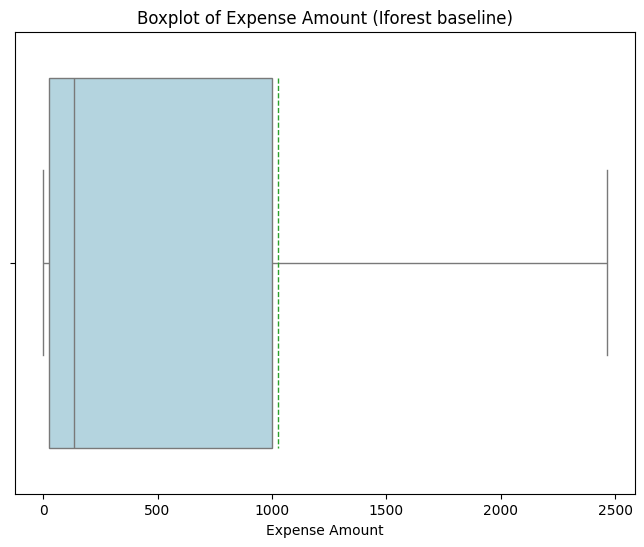

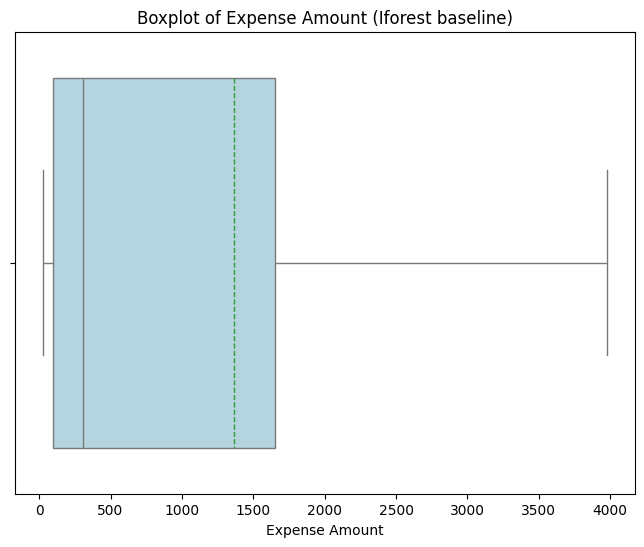

/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/4071158273.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_result_df = pd.concat([ad_result_df, new_row_df], ignore_index=True)
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/4071158273.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_result_df = pd.concat([ad_result_df, new_row_df], ignore_index=True)


In [427]:
base_ifor = IForestWrapper(name = 'baseline')
base_ifor.set_up_model()
X = df_scaled.drop(columns=['Employee ID'])
metrics_df_ifor_0 = base_ifor.fit_and_predict(X)
anomalies_df_ifor_0, ano_claimant_df_ifor_0, anomaly_result_df_ifor_0, new_anomalies_df_ifor_0, new_ano_claimant_df_ifor_0, new_anomaly_result_df_ifor_0 = base_ifor.get_anomalies(df_encoded, metrics_df_ifor_0)
base_ifor.visualize_boxplot(anomalies_df_ifor_0)
base_ifor.visualize_boxplot(new_anomalies_df_ifor_0)
ad_result_df = base_ifor.update_ad_result(ad_result_df, anomalies_df_ifor_0, anomaly_result_df_ifor_0)
new_ad_result_df = base_ifor.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_0, new_anomaly_result_df_ifor_0)

In [387]:
ad_result_df


,model_name,perc_anomaly_claim,perc_claimnts_with_ano_claims,perc_suspisiou_claimnts,avg_expense,min_expense,quarter1_expense,median_expense,quarter3_expense,max_expense,num_anomaly_claim,num_claimnts_with_ano_claims,num_suspicious_claimnts
0,IForest baseline,0.0982,0.3523,0.0564,1024.669368,0.004286,27.01,133.34,1001.0,291107.4,62439,5188,830


### LOF

In [355]:
# base_lof = LOFWrapper(name='baseline')
# base_lof.set_up_model()
# X = df_scaled.drop(columns=['Employee ID'])
# metrics_df_lof_0 = base_lof.fit_and_predict(X)
# anomalies_df_lof_0, ano_claimant_df_lof_0, anomaly_result_df_lof_0 = base_lof.get_anomalies(df_encoded, metrics_df_lof_0)


## AE

/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02625298 0.02625298 0.02625298 ... 0.01670644 0.01670644 0.00238663]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.3465067  0.298518   0.26887791 ... 0.17219478 0.1863091  0.17501764]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

Epoch [1/50], Training Loss: 0.2272, Validation Loss: 0.3040
Epoch [2/50], Training Loss: 0.3666, Validation Loss: 0.3671
Epoch [3/50], Training Loss: 0.3521, Validation Loss: 0.3206
Epoch [4/50], Training Loss: 0.3018, Validation Loss: 0.2750
Epoch [5/50], Training Loss: 0.2598, Validation Loss: 0.2381
Epoch [6/50], Training Loss: 0.2286, Validation Loss: 0.2181
Epoch [7/50], Training Loss: 0.2047, Validation Loss: 0.1919
Epoch [8/50], Training Loss: 0.1799, Validation Loss: 0.1717
Epoch [9/50], Training Loss: 0.1584, Validation Loss: 0.1502
Epoch [10/50], Training Loss: 0.1429, Validation Loss: 0.1428
Epoch [11/50], Training Loss: 0.1295, Validation Loss: 0.1309
Epoch [12/50], Training Loss: 0.1358, Validation Loss: 0.1386
Epoch [13/50], Training Loss: 0.1293, Validation Loss: 0.1250
Epoch [14/50], Training Loss: 0.1143, Validation Loss: 0.1255
Epoch [15/50], Training Loss: 0.1178, Validation Loss: 0.1185
Epoch [16/50], Training Loss: 0.1097, Validation Loss: 0.1099
Epoch [17/50], Tr

  0%|          | 0/100 [00:00<?, ?it/s]

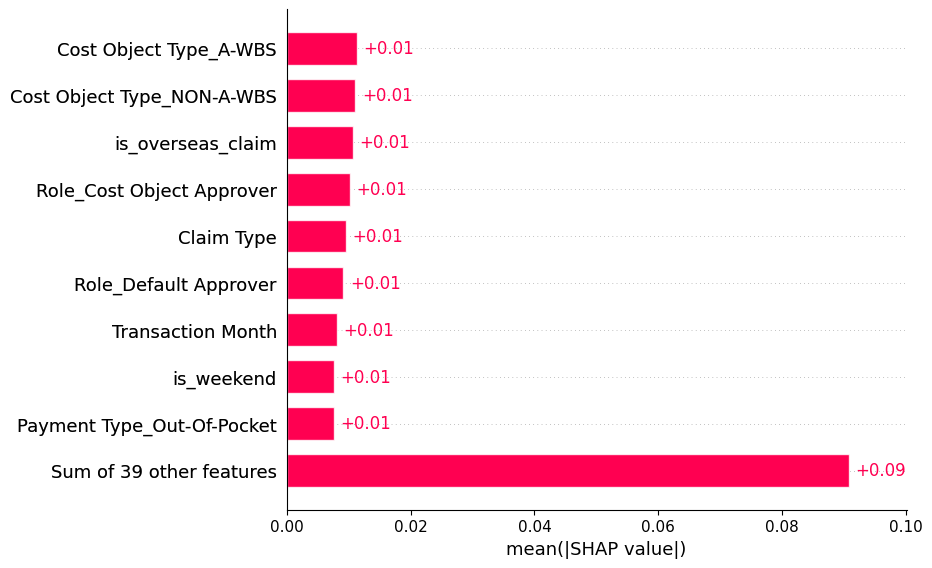

In [357]:
criterion = nn.MSELoss() 
activity_lambda = 0.01

ae_1 = AutoencoderWrapper(name = '1', criterion=criterion, cv='id_based', activity_lambda=activity_lambda)
train_loader, val_loader = ae_1.get_train_test(df_scaled)
ae_1.set_up_model(encoding_dim=16)

# early_stopping = EarlyStopping(patience=5, delta=0.01) 
loss_df_1 = ae_1.train(train_loader, val_loader)

bottleneck_df_1, reconstruct_error_df_1 = ae_1.get_bottleneck_and_error()

shap_values_1 = ae_1.get_shap()

/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.01767677 0.01262626 ... 0.08838384 0.00505051 0.00757576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.14548023 0.15254237 0.16101695 ... 0.15960452 0.16666667 0.16242938]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

Epoch [1/50], Training Loss: 0.3123, Validation Loss: 0.4447
Epoch [2/50], Training Loss: 0.4549, Validation Loss: 0.4642
Epoch [3/50], Training Loss: 0.4131, Validation Loss: 0.3997
Epoch [4/50], Training Loss: 0.3749, Validation Loss: 0.3541
Epoch [5/50], Training Loss: 0.3261, Validation Loss: 0.3061
Epoch [6/50], Training Loss: 0.2838, Validation Loss: 0.2695
Epoch [7/50], Training Loss: 0.2445, Validation Loss: 0.2096
Epoch [8/50], Training Loss: 0.2373, Validation Loss: 0.2499
Epoch [9/50], Training Loss: 0.2383, Validation Loss: 0.2329
Epoch [10/50], Training Loss: 0.2155, Validation Loss: 0.1935
Epoch [11/50], Training Loss: 0.2070, Validation Loss: 0.2101
Epoch [12/50], Training Loss: 0.2011, Validation Loss: 0.2076
Epoch [13/50], Training Loss: 0.2001, Validation Loss: 0.1976
Epoch [14/50], Training Loss: 0.1806, Validation Loss: 0.1713
Epoch [15/50], Training Loss: 0.1745, Validation Loss: 0.1773
Epoch [16/50], Training Loss: 0.1629, Validation Loss: 0.1741
Epoch [17/50], Tr

  0%|          | 0/100 [00:00<?, ?it/s]

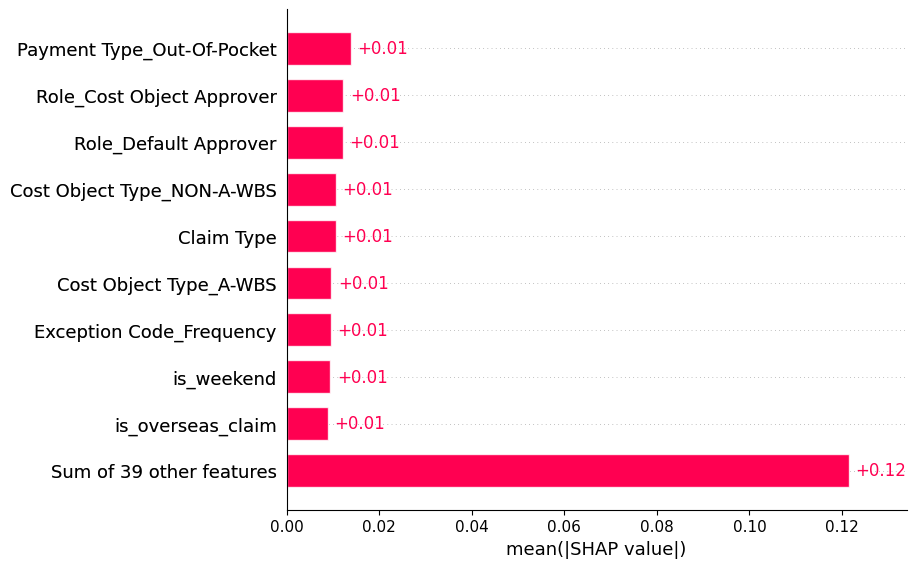

In [359]:
criterion = nn.MSELoss() 
activity_lambda = 0.01

ae_2 = AutoencoderWrapper(name = '2', criterion=criterion, cv='claim_based', activity_lambda=activity_lambda)
train_loader, val_loader = ae_2.get_train_test(df_scaled)
ae_2.set_up_model(encoding_dim=16)

loss_df_2 = ae_2.train(train_loader, val_loader)

bottleneck_df_2, reconstruct_error_df_2 = ae_2.get_bottleneck_and_error()

shap_values_2 = ae_2.get_shap()

## Combiantion

Comparison:
1. Anomaly rate: assume the smaller the better -> avoid overwhelm
2. Expense Amount of the anomalous claims: assume the larger the bettter -> avoid overwhelm
3. New indicator: anomalous claims (non-identity) + suspicious claimants (Identity related)




Insights:
1. Anomaly detection model: IForest is better than LOF, based on expense amount (although the anomaly rate of LOF model is much smaller)
2. CV: Seems like id-based CV is better than claim-based in both expense amount (higher) and anomaly percentage.
3. AE(id-based) + IForest: adding Expense Amount, the min expense amount become more reasonable



### AE + IForest

Special: exp on bottleneck

For model IForest built on AE (id-based CV) (remove 1st quarter):
                          model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE (id-based CV)               8668              0.0136   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          3200                         0.2173   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     3200                   0.2173  


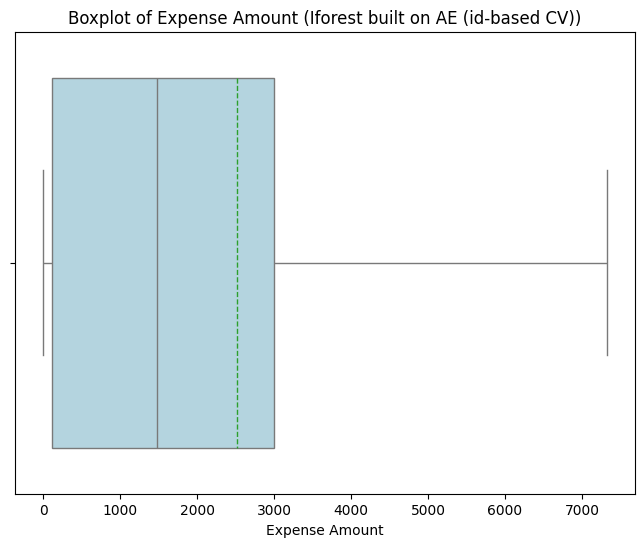

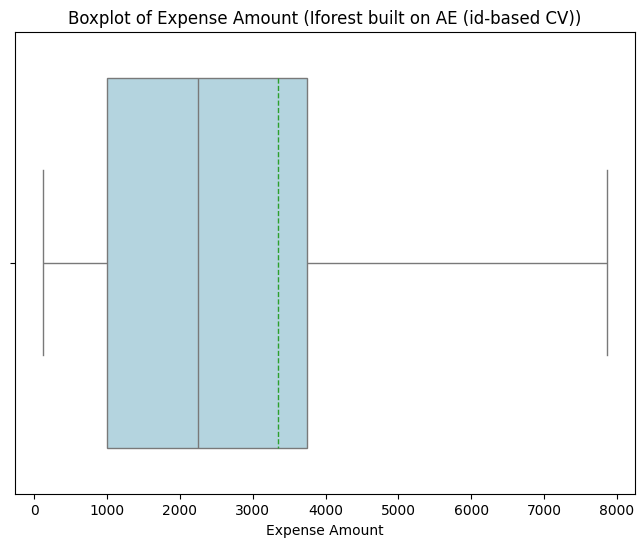

In [388]:
iforest_1=IForestWrapper('built on AE (id-based CV)')
iforest_1.set_up_model()
metrics_df_ifor_1 = iforest_1.fit_and_predict(np.exp(bottleneck_df_1)) 
anomalies_df_ifor_1, ano_claimant_df_ifor_1, anomaly_result_df_ifor_1, new_anomalies_df_ifor_1, new_ano_claimant_df_ifor_1, new_anomaly_result_df_ifor_1  = iforest_1.get_anomalies(df_encoded, metrics_df_ifor_1)
iforest_1.visualize_boxplot(anomalies_df_ifor_1)
iforest_1.visualize_boxplot(new_anomalies_df_ifor_1)
ad_result_df = iforest_1.update_ad_result(ad_result_df, anomalies_df_ifor_1, anomaly_result_df_ifor_1)
new_ad_result_df = iforest_1.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_1, new_anomaly_result_df_ifor_1)

For model IForest built on AE (claim-based CV) (remove 1st quarter):
                             model_name  num_anomaly_claim  \
0  IForest built on AE (claim-based CV)               5248   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0083                          1299   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.0882                     1299   

   perc_suspisiou_claimnts  
0                   0.0882  


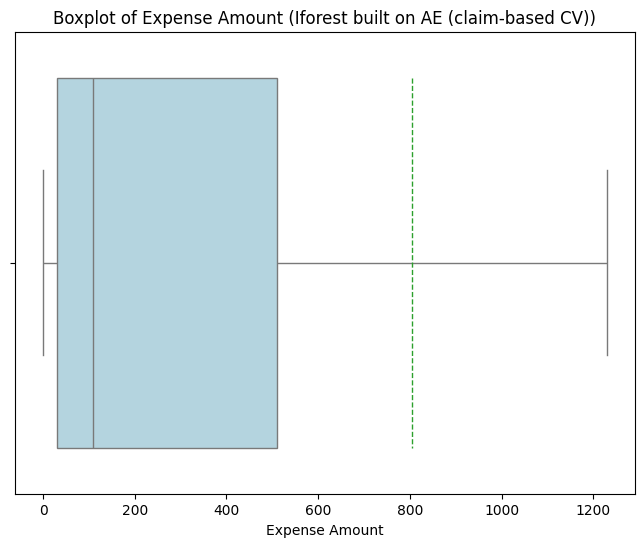

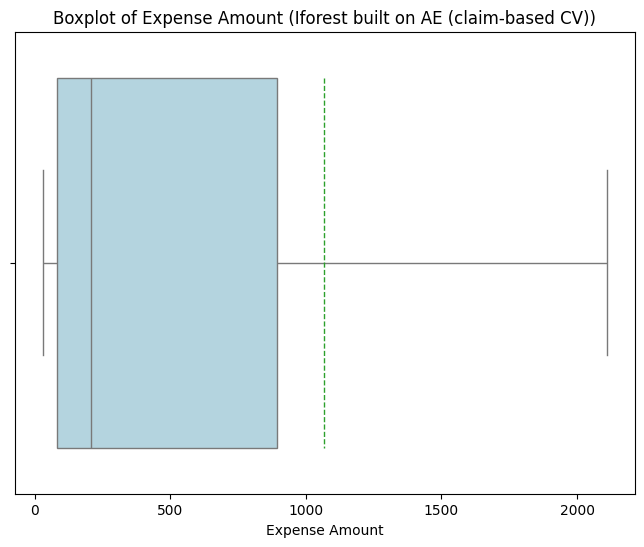

In [389]:
iforest_2=IForestWrapper('built on AE (claim-based CV)')
iforest_2.set_up_model()
metrics_df_ifor_2 = iforest_2.fit_and_predict(np.exp(bottleneck_df_2))
anomalies_df_ifor_2, ano_claimant_df_ifor_2, anomaly_result_df_ifor_2, new_anomalies_df_ifor_2, new_ano_claimant_df_ifor_2, new_anomaly_result_df_ifor_2 = iforest_2.get_anomalies(df_encoded, metrics_df_ifor_2)
iforest_2.visualize_boxplot(anomalies_df_ifor_2)
iforest_2.visualize_boxplot(new_anomalies_df_ifor_2)
ad_result_df = iforest_2.update_ad_result(ad_result_df, anomalies_df_ifor_2, anomaly_result_df_ifor_2)
new_ad_result_df = iforest_2.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_2, new_anomaly_result_df_ifor_2)

For model IForest built on AE (id-based CV) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (id-based CV) + expense am...              11107   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0175                          3649   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.2478                     3649   

   perc_suspisiou_claimnts  
0                   0.2478  


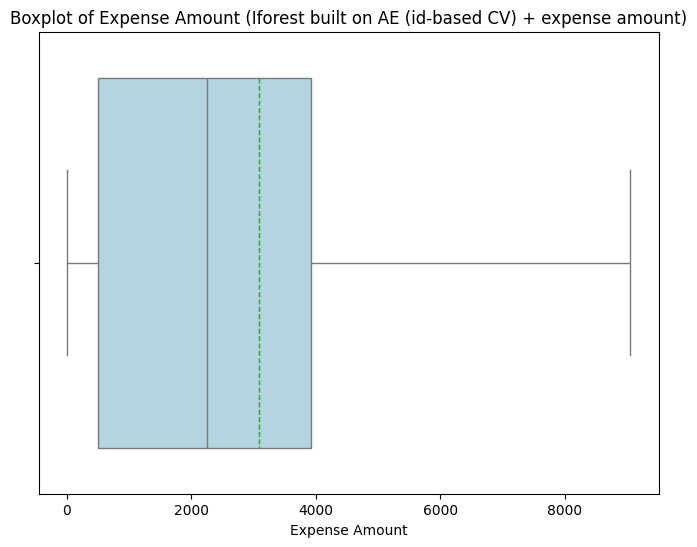

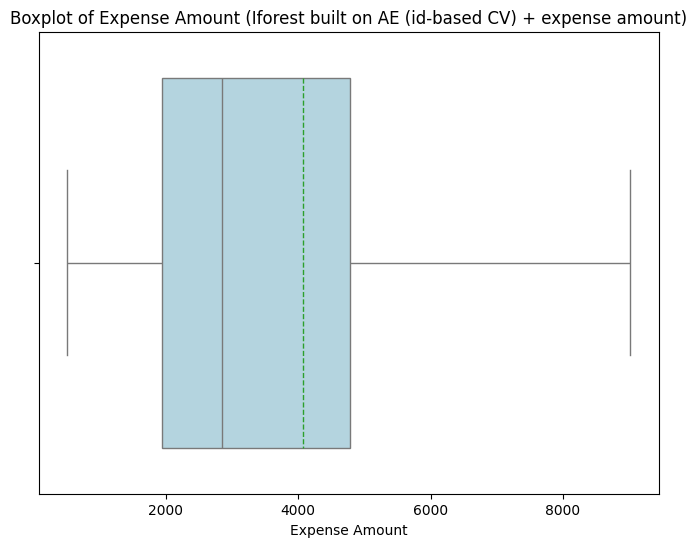

In [390]:
iforest_3=IForestWrapper('built on AE (id-based CV) + expense amount')
iforest_3.set_up_model()
X_ifor_3 = bottleneck_df_1.copy()
X_ifor_3 = np.exp(X_ifor_3)
X_ifor_3[16] = df_scaled['Expense Amount']
metrics_df_ifor_3 = iforest_3.fit_and_predict(X_ifor_3)
anomalies_df_ifor_3, ano_claimant_df_ifor_3, anomaly_result_df_ifor_3, new_anomalies_df_ifor_3, new_ano_claimant_df_ifor_3, new_anomaly_result_df_ifor_3 = iforest_3.get_anomalies(df_encoded, metrics_df_ifor_3)
iforest_3.visualize_boxplot(anomalies_df_ifor_3)
iforest_3.visualize_boxplot(new_anomalies_df_ifor_3)
ad_result_df = iforest_3.update_ad_result(ad_result_df, anomalies_df_ifor_3, anomaly_result_df_ifor_3)
new_ad_result_df = iforest_3.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_3, new_anomaly_result_df_ifor_3)

For model IForest built on AE (claim-based CV) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (claim-based CV) + expense...               5064   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0               0.008                          1644   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.1117                     1644   

   perc_suspisiou_claimnts  
0                   0.1117  


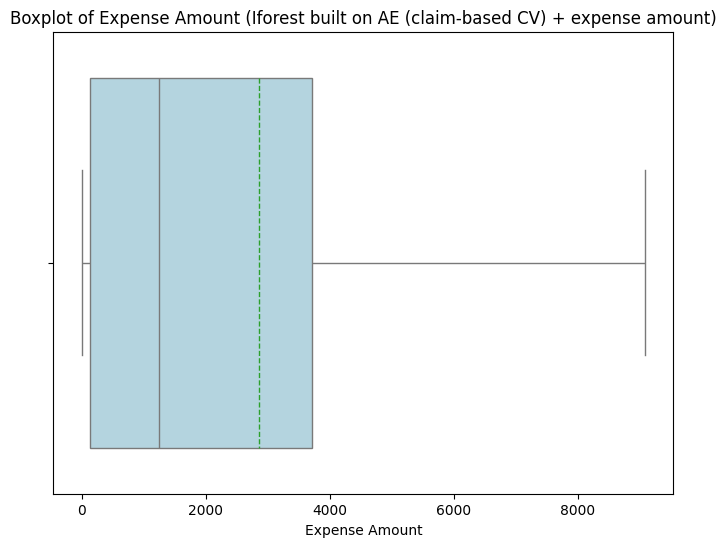

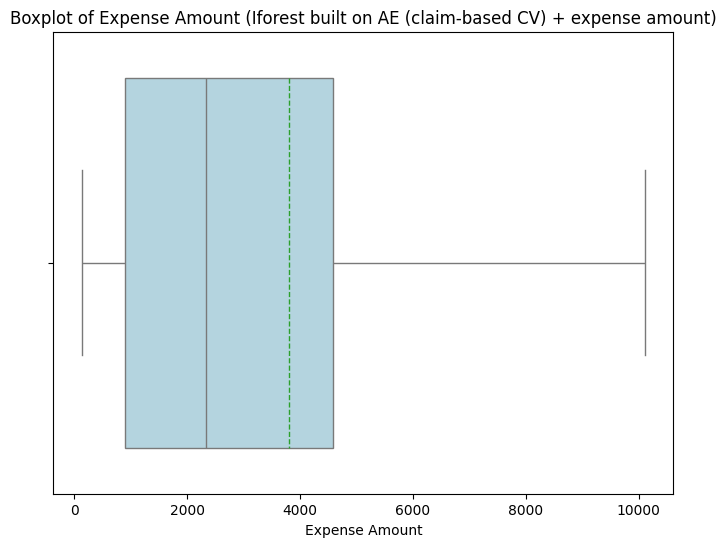

In [391]:
iforest_4=IForestWrapper('built on AE (claim-based CV) + expense amount')
iforest_4.set_up_model()
X_ifor_4 = bottleneck_df_2.copy()
X_ifor_4 = np.exp(X_ifor_4)
X_ifor_4[16] = df_scaled['Expense Amount']
metrics_df_ifor_4 = iforest_4.fit_and_predict(X_ifor_4)
anomalies_df_ifor_4, ano_claimant_df_ifor_4, anomaly_result_df_ifor_4, new_anomalies_df_ifor_4, new_ano_claimant_df_ifor_4, new_anomaly_result_df_ifor_4 = iforest_4.get_anomalies(df_encoded, metrics_df_ifor_4)
iforest_4.visualize_boxplot(anomalies_df_ifor_4)
iforest_4.visualize_boxplot(new_anomalies_df_ifor_4)
ad_result_df = iforest_4.update_ad_result(ad_result_df, anomalies_df_ifor_4, anomaly_result_df_ifor_4)
new_ad_result_df = iforest_4.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_4, new_anomaly_result_df_ifor_4)

For model IForest built on AE error (id-based) (remove 1st quarter):
                             model_name  num_anomaly_claim  \
0  IForest built on AE error (id-based)              34886   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0549                          6502   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4416                     6502   

   perc_suspisiou_claimnts  
0                   0.4416  


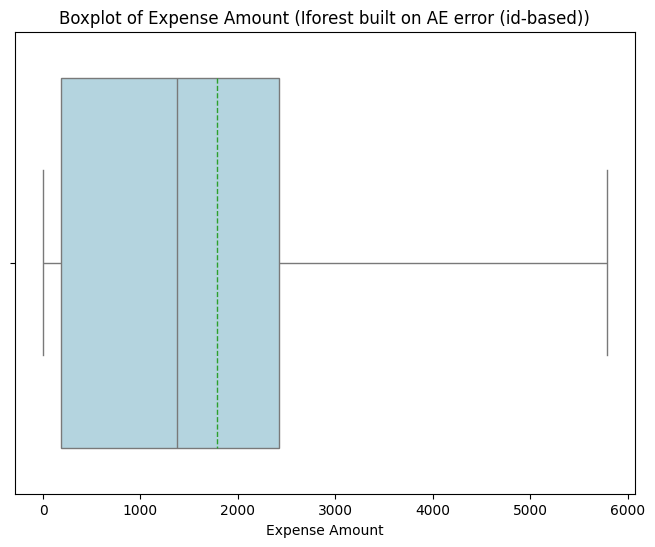

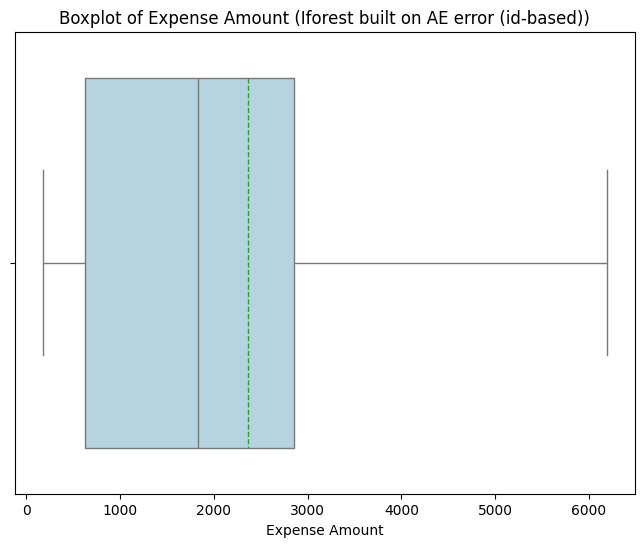

In [392]:
iforest_5=IForestWrapper('built on AE error (id-based)')
iforest_5.set_up_model()
X_ifor_5 = reconstruct_error_df_1.copy()
metrics_df_ifor_5 = iforest_5.fit_and_predict(X_ifor_5)
anomalies_df_ifor_5, ano_claimant_df_ifor_5, anomaly_result_df_ifor_5, new_anomalies_df_ifor_5, new_ano_claimant_df_ifor_5, new_anomaly_result_df_ifor_5 = iforest_5.get_anomalies(df_encoded, metrics_df_ifor_5)
iforest_5.visualize_boxplot(anomalies_df_ifor_5)
iforest_5.visualize_boxplot(new_anomalies_df_ifor_5)   
ad_result_df = iforest_5.update_ad_result(ad_result_df, anomalies_df_ifor_5, anomaly_result_df_ifor_5)
new_ad_result_df = iforest_5.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_5, new_anomaly_result_df_ifor_5)

For model IForest built on AE error (id-based) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE error (id-based) + expense...              52271   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0822                          7337   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4983                     7337   

   perc_suspisiou_claimnts  
0                   0.4983  


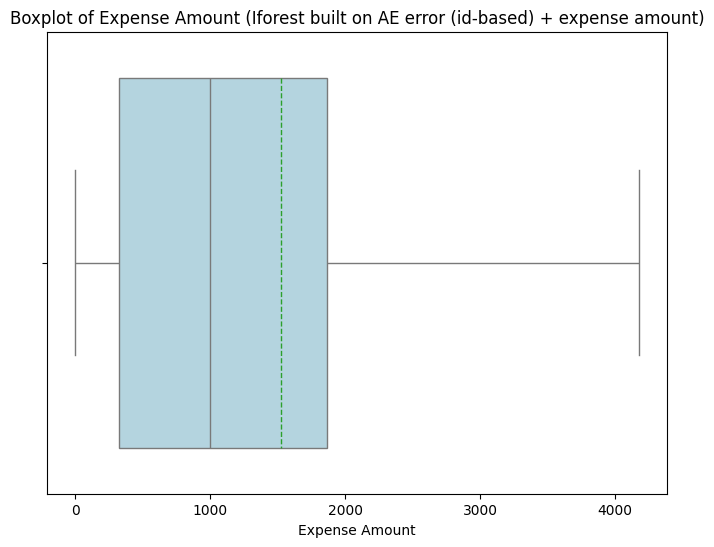

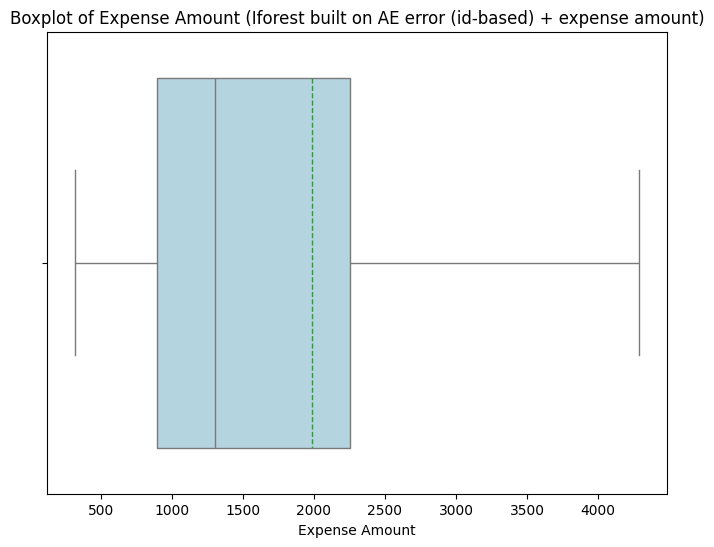

In [393]:
iforest_6=IForestWrapper('built on AE error (id-based) + expense amount')
iforest_6.set_up_model()
X_ifor_6 = reconstruct_error_df_1.copy()
X_ifor_6['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_ifor_6 = iforest_6.fit_and_predict(X_ifor_6)
anomalies_df_ifor_6, ano_claimant_df_ifor_6, anomaly_result_df_ifor_6, new_anomalies_df_ifor_6, new_ano_claimant_df_ifor_6, new_anomaly_result_df_ifor_6 = iforest_6.get_anomalies(df_encoded, metrics_df_ifor_6)
iforest_6.visualize_boxplot(anomalies_df_ifor_6)
iforest_6.visualize_boxplot(new_anomalies_df_ifor_6)
ad_result_df = iforest_6.update_ad_result(ad_result_df, anomalies_df_ifor_6, anomaly_result_df_ifor_6)
new_ad_result_df = iforest_6.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_6, new_anomaly_result_df_ifor_6)

For model IForest built on AE(id) + error (remove 1st quarter):
                        model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE(id) + error              25351              0.0399   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          5005                         0.3399   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     5005                   0.3399  


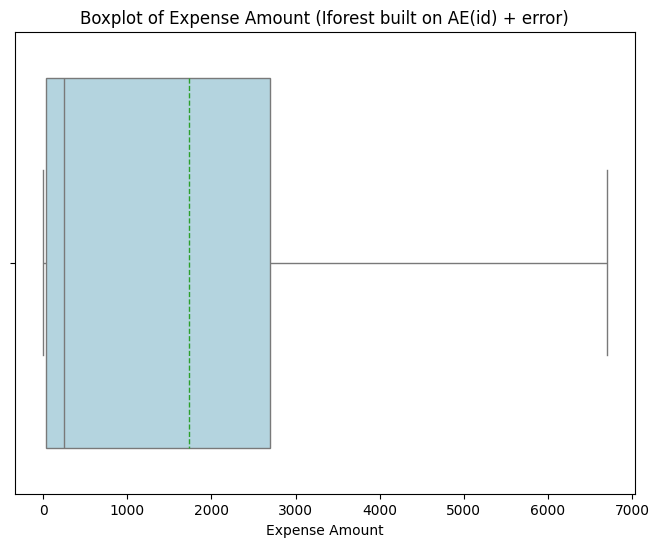

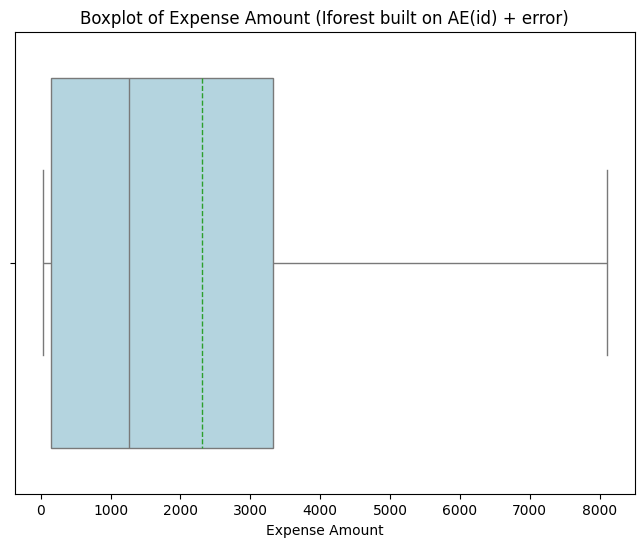

In [394]:
iforest_7=IForestWrapper('built on AE(id) + error') # same as scaled expense amount
iforest_7.set_up_model()
X_ifor_7 = bottleneck_df_1.copy()
X_ifor_7[16] = reconstruct_error_df_1['reconstruction_error']
# X_ifor_7[17] = df_encoded['Expense Amount']
metrics_df_ifor_7 = iforest_7.fit_and_predict(X_ifor_7)
anomalies_df_ifor_7, ano_claimant_df_ifor_7, anomaly_result_df_ifor_7, new_anomalies_df_ifor_7, new_ano_claimant_df_ifor_7, new_anomaly_result_df_ifor_7 = iforest_7.get_anomalies(df_encoded, metrics_df_ifor_7)
iforest_7.visualize_boxplot(anomalies_df_ifor_7)
iforest_7.visualize_boxplot(new_anomalies_df_ifor_7)
ad_result_df = iforest_7.update_ad_result(ad_result_df, anomalies_df_ifor_7, anomaly_result_df_ifor_7)
new_ad_result_df = iforest_7.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_7, new_anomaly_result_df_ifor_7)

For model IForest built on AE(id) + error + expense (remove 1st quarter):
                                  model_name  num_anomaly_claim  \
0  IForest built on AE(id) + error + expense              24993   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0393                          5487   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.3727                     5487   

   perc_suspisiou_claimnts  
0                   0.3727  


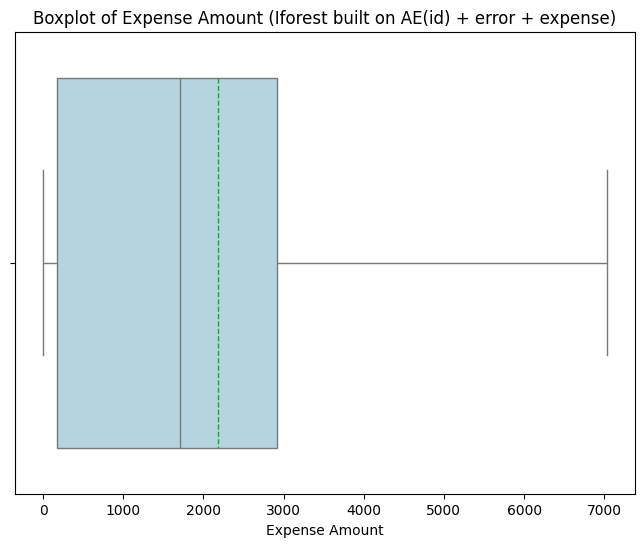

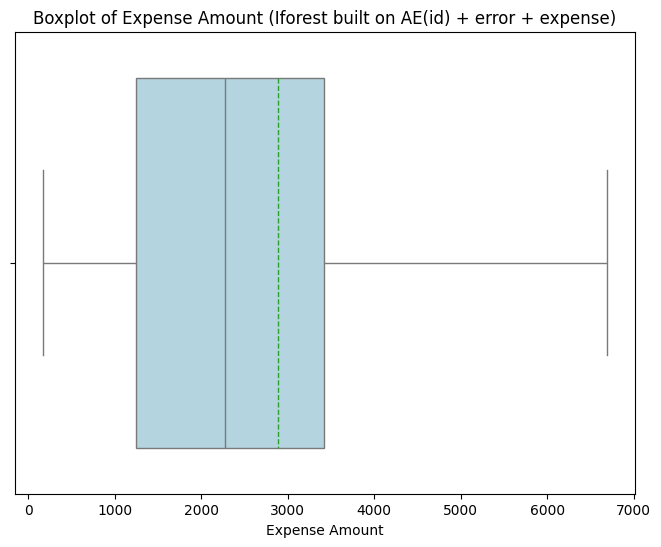

In [395]:
iforest_8=IForestWrapper('built on AE(id) + error + expense') # same as original expense amount
iforest_8.set_up_model()
X_ifor_8 = bottleneck_df_1.copy()
X_ifor_8[16] = reconstruct_error_df_1['reconstruction_error']
X_ifor_8[17] = df_scaled['Expense Amount']
metrics_df_ifor_8 = iforest_8.fit_and_predict(X_ifor_8)
anomalies_df_ifor_8, ano_claimant_df_ifor_8, anomaly_result_df_ifor_8, new_anomalies_df_ifor_8, new_ano_claimant_df_ifor_8, new_anomaly_result_df_ifor_8 = iforest_8.get_anomalies(df_encoded, metrics_df_ifor_8)
iforest_8.visualize_boxplot(anomalies_df_ifor_8)
iforest_8.visualize_boxplot(new_anomalies_df_ifor_8)
ad_result_df = iforest_8.update_ad_result(ad_result_df, anomalies_df_ifor_8, anomaly_result_df_ifor_8)
new_ad_result_df = iforest_8.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_8, new_anomaly_result_df_ifor_8)

For model IForest built on AE error (claim-based) (remove 1st quarter):
                                model_name  num_anomaly_claim  \
0  IForest built on AE error (claim-based)              42487   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0668                          6148   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4175                     6148   

   perc_suspisiou_claimnts  
0                   0.4175  


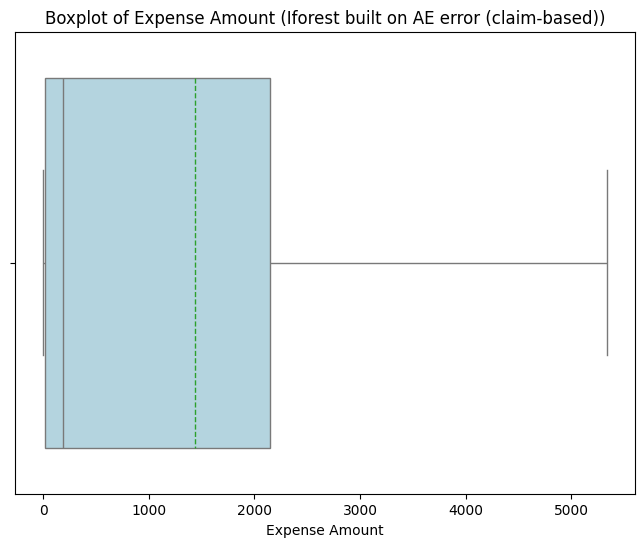

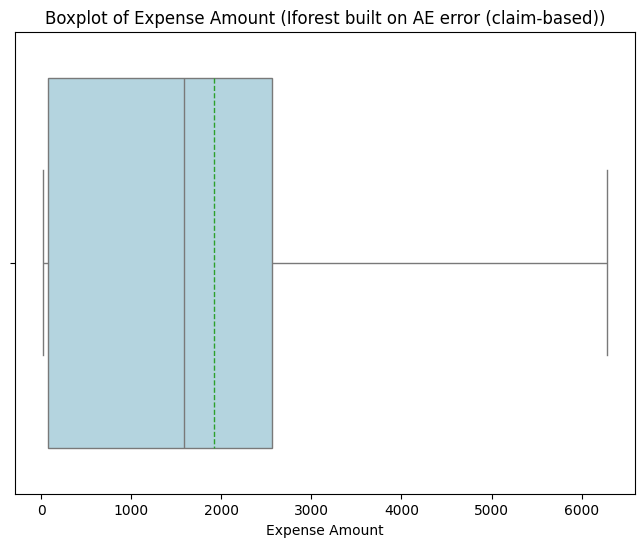

In [396]:
iforest_9=IForestWrapper('built on AE error (claim-based)')
iforest_9.set_up_model()
X_ifor_9 = reconstruct_error_df_2.copy()
metrics_df_ifor_9 = iforest_9.fit_and_predict(X_ifor_9)
anomalies_df_ifor_9, ano_claimant_df_ifor_9, anomaly_result_df_ifor_9, new_anomalies_df_ifor_9, new_ano_claimant_df_ifor_9, new_anomaly_result_df_ifor_9 = iforest_9.get_anomalies(df_encoded, metrics_df_ifor_9)
iforest_9.visualize_boxplot(anomalies_df_ifor_9)
iforest_9.visualize_boxplot(new_anomalies_df_ifor_9)
ad_result_df = iforest_9.update_ad_result(ad_result_df, anomalies_df_ifor_9, anomaly_result_df_ifor_9)
new_ad_result_df = iforest_9.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_9, new_anomaly_result_df_ifor_9)

For model IForest built on AE error (claim-based) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE error (claim-based) + expe...              55835   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0878                          7114   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4832                     7114   

   perc_suspisiou_claimnts  
0                   0.4832  


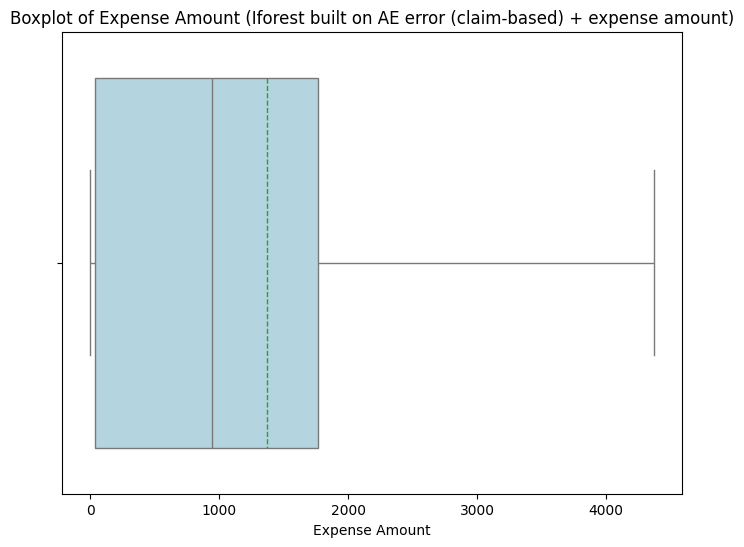

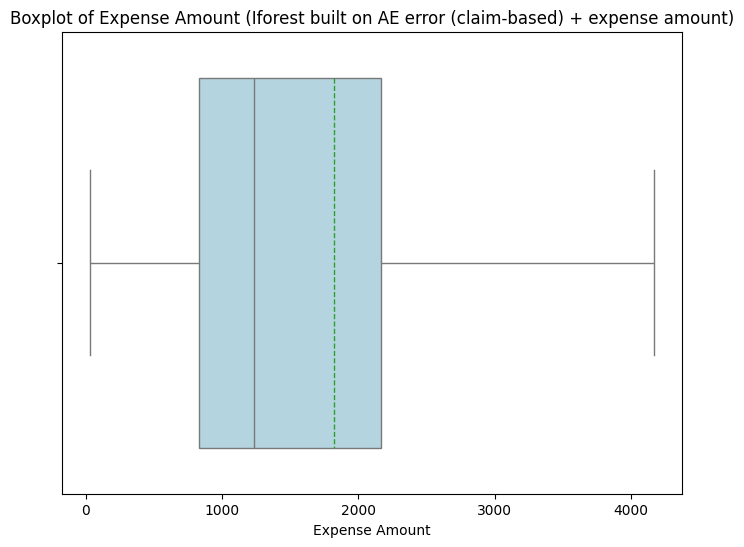

In [397]:
iforest_10=IForestWrapper('built on AE error (claim-based) + expense amount')
iforest_10.set_up_model()
X_ifor_10 = reconstruct_error_df_2.copy()
X_ifor_10['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_ifor_10 = iforest_10.fit_and_predict(X_ifor_10)
anomalies_df_ifor_10, ano_claimant_df_ifor_10, anomaly_result_df_ifor_10, new_anomalies_df_ifor_10, new_ano_claimant_df_ifor_10, new_anomaly_result_df_ifor_10 = iforest_10.get_anomalies(df_encoded, metrics_df_ifor_10)
iforest_10.visualize_boxplot(anomalies_df_ifor_10)
iforest_10.visualize_boxplot(new_anomalies_df_ifor_10)
ad_result_df = iforest_10.update_ad_result(ad_result_df, anomalies_df_ifor_10, anomaly_result_df_ifor_10)
new_ad_result_df = iforest_10.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_10, new_anomaly_result_df_ifor_10)

For model IForest built on AE(claim) + error (remove 1st quarter):
                           model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE(claim) + error              27793              0.0437   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          5532                         0.3757   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     5532                   0.3757  


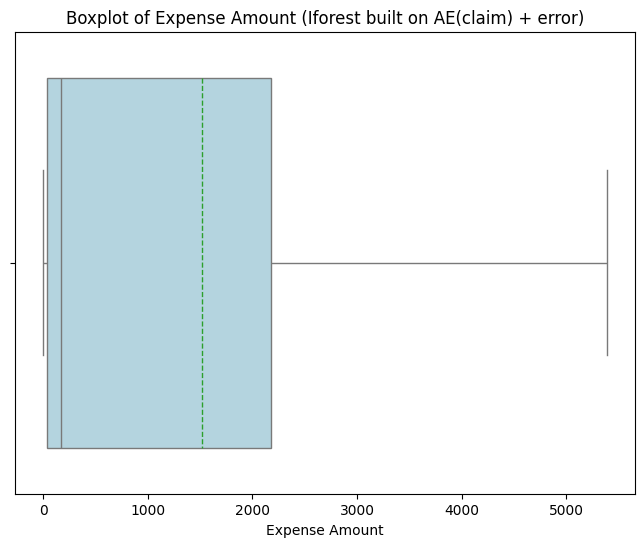

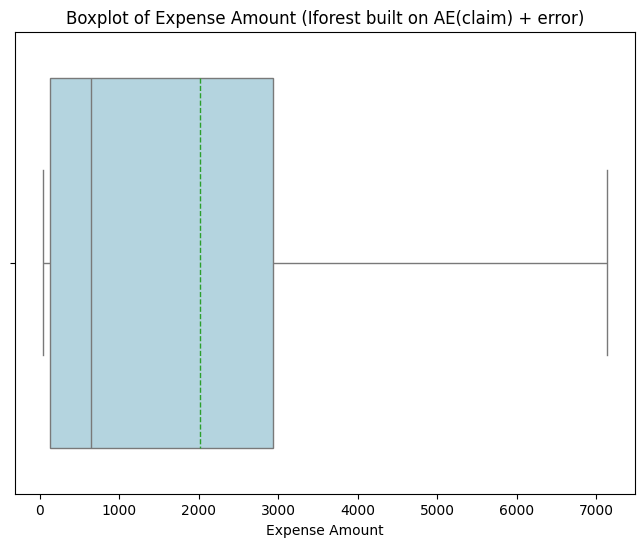

In [398]:
iforest_11=IForestWrapper('built on AE(claim) + error') 
iforest_11.set_up_model()
X_ifor_11 = bottleneck_df_2.copy()
X_ifor_11[16] = reconstruct_error_df_2['reconstruction_error']
# X_ifor_11[17] = df_encoded['Expense Amount']
metrics_df_ifor_11 = iforest_11.fit_and_predict(X_ifor_11)
anomalies_df_ifor_11, ano_claimant_df_ifor_11, anomaly_result_df_ifor_11, new_anomalies_df_ifor_11, new_ano_claimant_df_ifor_11, new_anomaly_result_df_ifor_11 = iforest_11.get_anomalies(df_encoded, metrics_df_ifor_11)
iforest_11.visualize_boxplot(anomalies_df_ifor_11)
iforest_11.visualize_boxplot(new_anomalies_df_ifor_11)
ad_result_df = iforest_11.update_ad_result(ad_result_df, anomalies_df_ifor_11, anomaly_result_df_ifor_11)
new_ad_result_df = iforest_11.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_11, new_anomaly_result_df_ifor_11)

For model IForest built on AE(claim) + error + expense (remove 1st quarter):
                                     model_name  num_anomaly_claim  \
0  IForest built on AE(claim) + error + expense              31200   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0491                          5781   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.3926                     5781   

   perc_suspisiou_claimnts  
0                   0.3926  


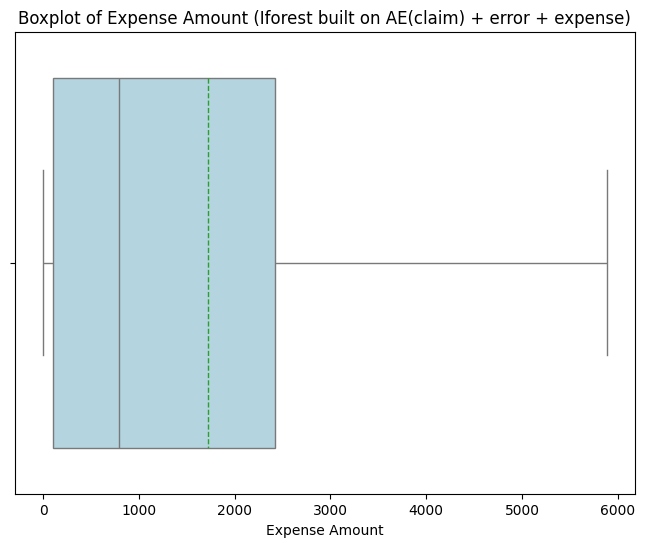

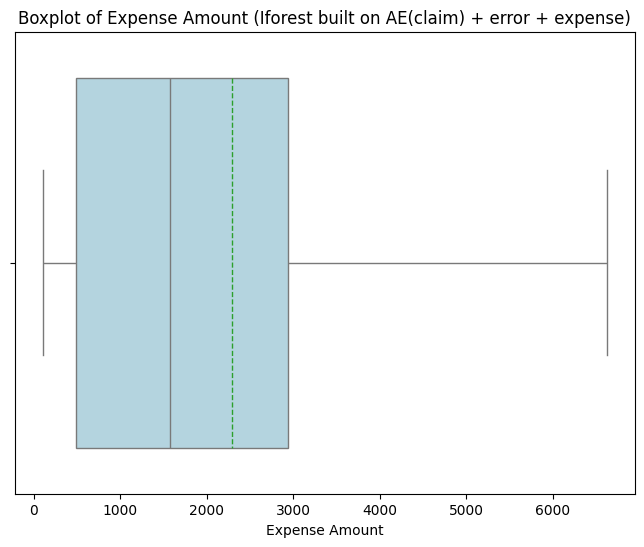

In [399]:
iforest_12=IForestWrapper('built on AE(claim) + error + expense') # same as original expense amount
iforest_12.set_up_model()
X_ifor_12 = bottleneck_df_2.copy()
X_ifor_12[16] = reconstruct_error_df_2['reconstruction_error']
X_ifor_12[17] = df_scaled['Expense Amount']
metrics_df_ifor_12 = iforest_12.fit_and_predict(X_ifor_12)
anomalies_df_ifor_12, ano_claimant_df_ifor_12, anomaly_result_df_ifor_12, new_anomalies_df_ifor_12, new_ano_claimant_df_ifor_12, new_anomaly_result_df_ifor_12 = iforest_12.get_anomalies(df_encoded, metrics_df_ifor_12)
iforest_12.visualize_boxplot(anomalies_df_ifor_12)
iforest_12.visualize_boxplot(new_anomalies_df_ifor_12)
ad_result_df = iforest_12.update_ad_result(ad_result_df, anomalies_df_ifor_12, anomaly_result_df_ifor_12)
new_ad_result_df = iforest_12.update_ad_result(new_ad_result_df, new_anomalies_df_ifor_12, new_anomaly_result_df_ifor_12)

### AE + LOF

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE (id-based CV) (remove 1st quarter):
                          model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE (id-based CV)               1314              0.0021   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                           908                         0.0617   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                      908                   0.0617  


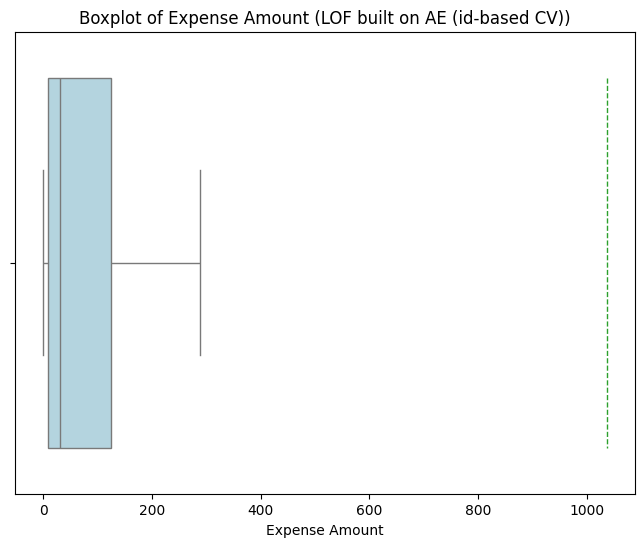

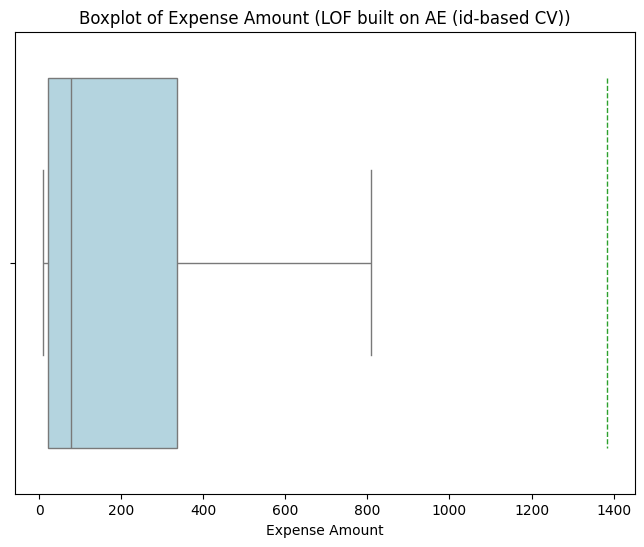

In [400]:
lof_1 = LOFWrapper('built on AE (id-based CV)')
lof_1.set_up_model()
metrics_df_lof_1 = lof_1.fit_and_predict(reconstruct_error_df_1)
anomalies_df_lof_1, ano_claimant_df_lof_1, anomaly_result_df_lof_1, new_anomalies_df_lof_1, new_ano_claimant_df_lof_1, new_anomaly_result_df_lof_1 = lof_1.get_anomalies(df_encoded, metrics_df_lof_1)
lof_1.visualize_boxplot(anomalies_df_lof_1)
lof_1.visualize_boxplot(new_anomalies_df_lof_1)
ad_result_df = lof_1.update_ad_result(ad_result_df, anomalies_df_lof_1, anomaly_result_df_lof_1)
new_ad_result_df = lof_1.update_ad_result(new_ad_result_df, new_anomalies_df_lof_1, new_anomaly_result_df_lof_1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE (claim-based CV) (remove 1st quarter):
                             model_name  num_anomaly_claim  \
0  IForest built on AE (claim-based CV)                642   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0               0.001                           540   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.0367                      540   

   perc_suspisiou_claimnts  
0                   0.0367  


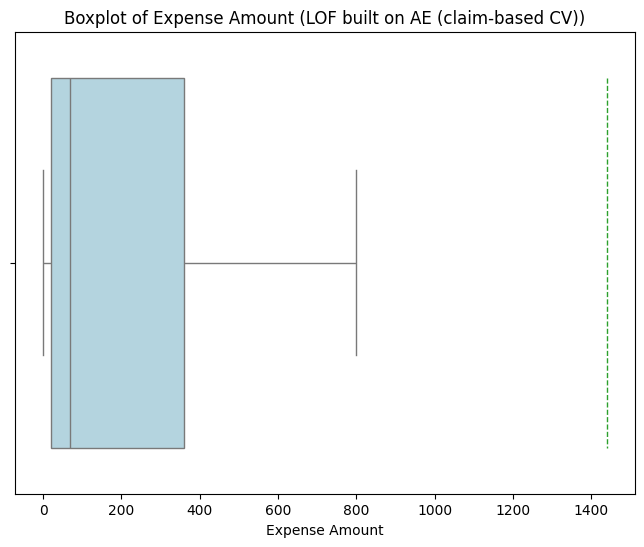

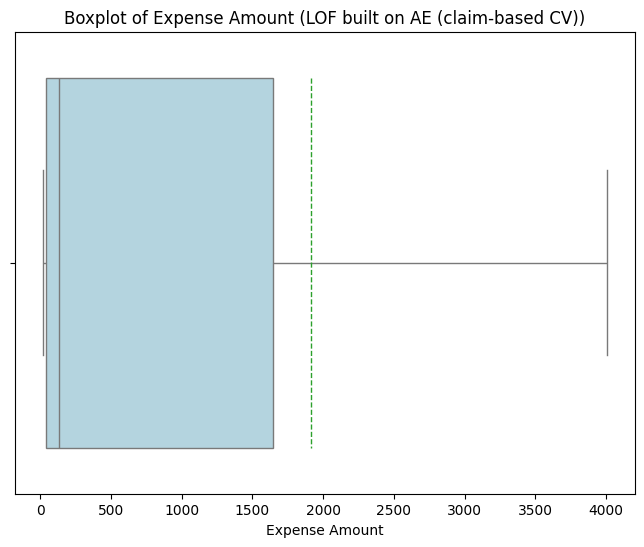

In [401]:
lof_2 = LOFWrapper('built on AE (claim-based CV)')
lof_2.set_up_model()
metrics_df_lof_2 = lof_2.fit_and_predict(reconstruct_error_df_2)
anomalies_df_lof_2, ano_claimant_df_lof_2, anomaly_result_df_lof_2, new_anomalies_df_lof_2, new_ano_claimant_df_lof_2, new_anomaly_result_df_lof_2 = lof_2.get_anomalies(df_encoded, metrics_df_lof_2)
lof_2.visualize_boxplot(anomalies_df_lof_2)
lof_2.visualize_boxplot(new_anomalies_df_lof_2)
ad_result_df = lof_2.update_ad_result(ad_result_df, anomalies_df_lof_2, anomaly_result_df_lof_2)
new_ad_result_df = lof_2.update_ad_result(new_ad_result_df, new_anomalies_df_lof_2, new_anomaly_result_df_lof_2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE(id) + expense (remove 1st quarter):
                          model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE(id) + expense              65973              0.1037   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          8824                         0.5993   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     8824                   0.5993  


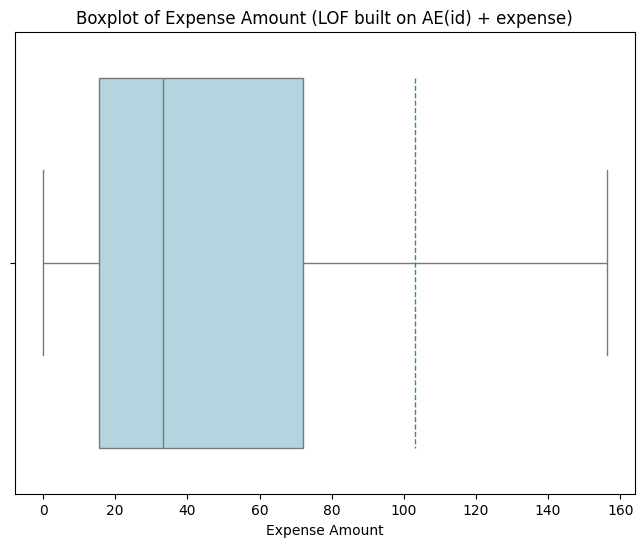

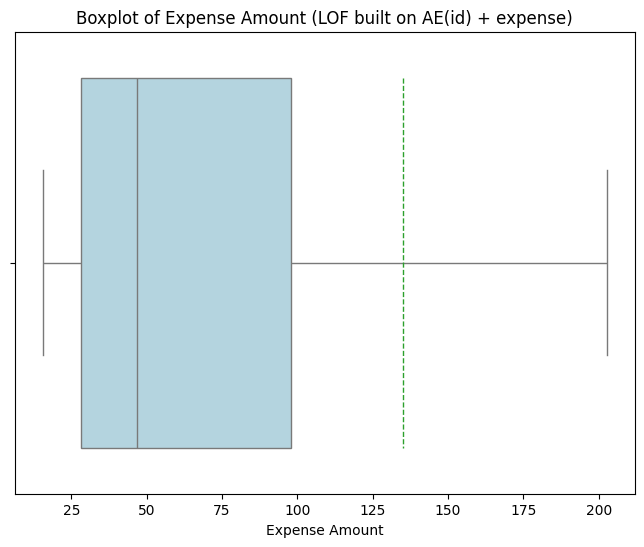

In [402]:
lof_3 = LOFWrapper('built on AE(id) + expense')
lof_3.set_up_model()
X_lof_3 = reconstruct_error_df_1.copy()
X_lof_3['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_lof_3 = lof_3.fit_and_predict(X_lof_3)
anomalies_df_lof_3, ano_claimant_df_lof_3, anomaly_result_df_lof_3, new_anomalies_df_lof_3, new_ano_claimant_df_lof_3, new_anomaly_result_df_lof_3 = lof_3.get_anomalies(df_encoded, metrics_df_lof_3)
lof_3.visualize_boxplot(anomalies_df_lof_3)
lof_3.visualize_boxplot(new_anomalies_df_lof_3)
ad_result_df = lof_3.update_ad_result(ad_result_df, anomalies_df_lof_3, anomaly_result_df_lof_3)
new_ad_result_df = lof_3.update_ad_result(new_ad_result_df, new_anomalies_df_lof_3, new_anomaly_result_df_lof_3)

In [428]:
metrics_df_lof_3

,scores,anomaly_score,index
0,0.499717,1,0
1,0.428561,1,1
2,0.516410,1,2
3,-124.071346,-1,3
4,0.515042,1,4
...,...,...,...
636001,0.462885,1,636001
636002,0.451638,1,636002
636003,0.445389,1,636003
636004,0.396606,1,636004


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE(id) + expense (remove 1st quarter):
                          model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE(id) + expense              65973              0.1037   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          8824                         0.5993   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     8824                   0.5993  


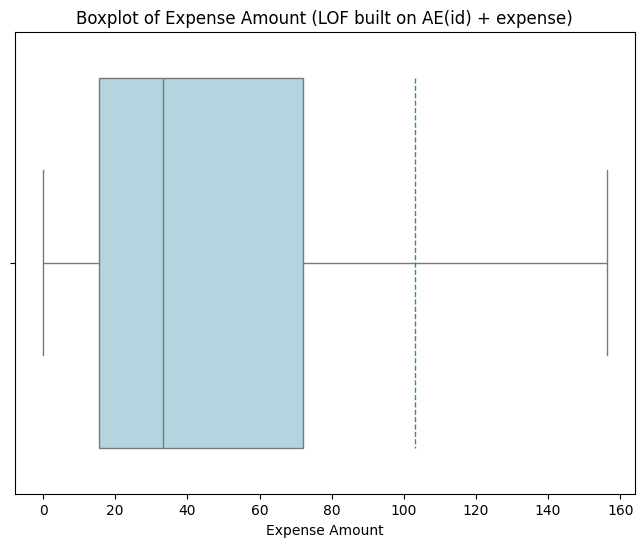

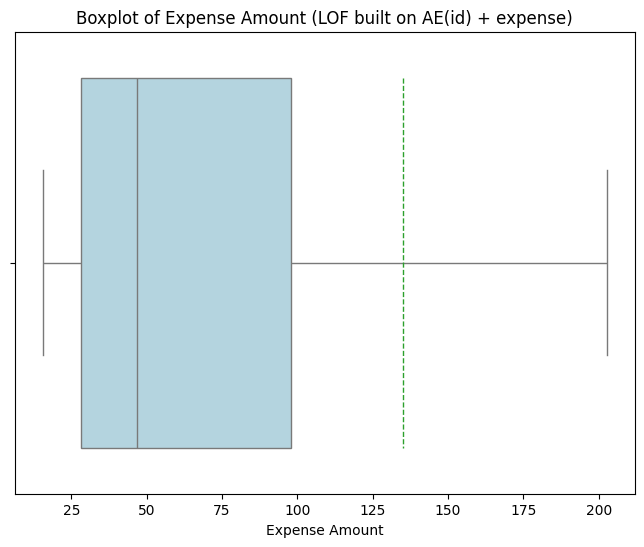

In [403]:
lof_4 = LOFWrapper('built on AE(id) + expense')
lof_4.set_up_model()
X_lof_4 = reconstruct_error_df_1.copy()
X_lof_4['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_lof_4 = lof_4.fit_and_predict(X_lof_4)
anomalies_df_lof_4, ano_claimant_df_lof_4, anomaly_result_df_lof_4, new_anomalies_df_lof_4, new_ano_claimant_df_lof_4, new_anomaly_result_df_lof_4 = lof_4.get_anomalies(df_encoded, metrics_df_lof_4)
lof_4.visualize_boxplot(anomalies_df_lof_4)
lof_4.visualize_boxplot(new_anomalies_df_lof_4)
ad_result_df = lof_4.update_ad_result(ad_result_df, anomalies_df_lof_4, anomaly_result_df_lof_4)
new_ad_result_df = lof_4.update_ad_result(new_ad_result_df, new_anomalies_df_lof_4, new_anomaly_result_df_lof_4)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE(claim) + expense (remove 1st quarter):
                             model_name  num_anomaly_claim  \
0  IForest built on AE(claim) + expense              58371   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0918                          8502   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.5774                     8502   

   perc_suspisiou_claimnts  
0                   0.5774  


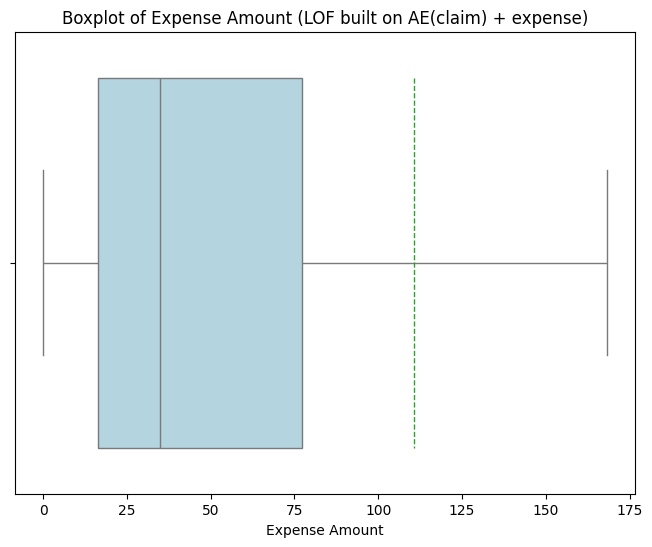

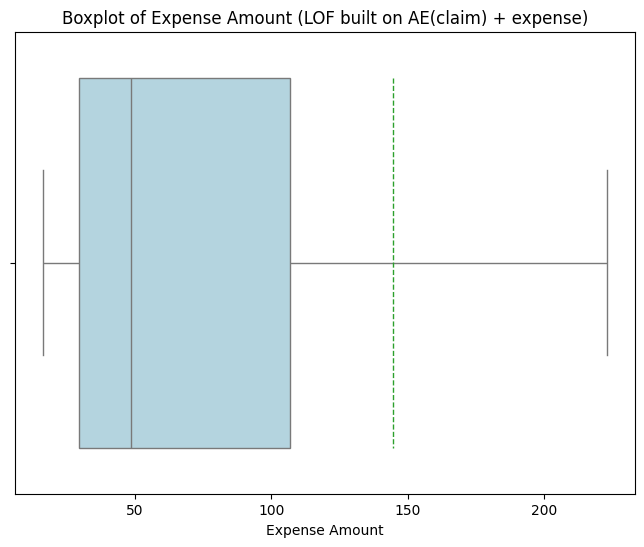

In [404]:
lof_5 = LOFWrapper('built on AE(claim) + expense')
lof_5.set_up_model()
X_lof_5 = reconstruct_error_df_2.copy()
X_lof_5['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_lof_5 = lof_5.fit_and_predict(X_lof_5)
anomalies_df_lof_5, ano_claimant_df_lof_5, anomaly_result_df_lof_5, new_anomalies_df_lof_5, new_ano_claimant_df_lof_5, new_anomaly_result_df_lof_5 = lof_5.get_anomalies(df_encoded, metrics_df_lof_5)
lof_5.visualize_boxplot(anomalies_df_lof_5)
lof_5.visualize_boxplot(new_anomalies_df_lof_5)
ad_result_df = lof_5.update_ad_result(ad_result_df, anomalies_df_lof_5, anomaly_result_df_lof_5)
new_ad_result_df = lof_5.update_ad_result(new_ad_result_df, new_anomalies_df_lof_5, new_anomaly_result_df_lof_5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


For model IForest built on AE(claim) + expense (remove 1st quarter):
                             model_name  num_anomaly_claim  \
0  IForest built on AE(claim) + expense              58371   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0918                          8502   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.5774                     8502   

   perc_suspisiou_claimnts  
0                   0.5774  


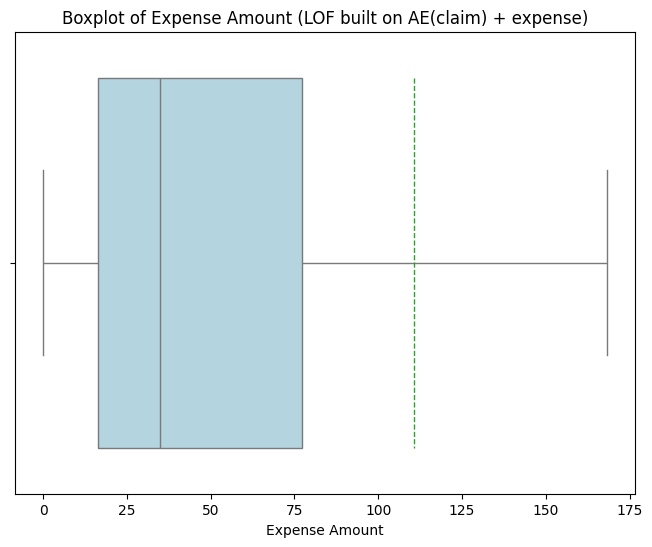

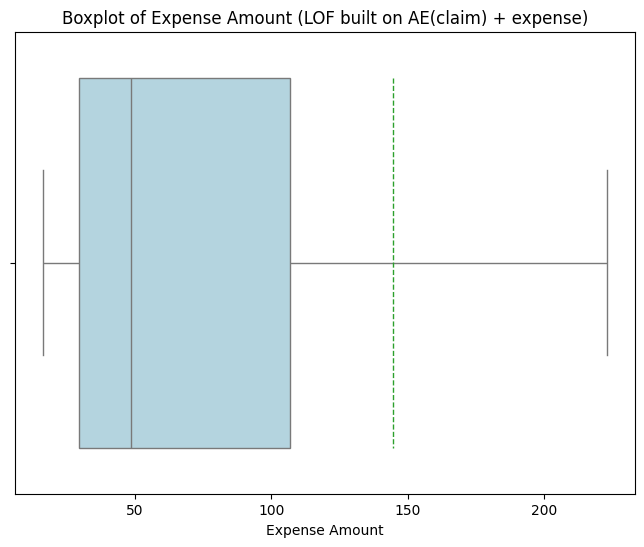

In [405]:
lof_6 = LOFWrapper('built on AE(claim) + expense')
lof_6.set_up_model()
X_lof_6 = reconstruct_error_df_2.copy()
X_lof_6['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_lof_6 = lof_6.fit_and_predict(X_lof_6)
anomalies_df_lof_6, ano_claimant_df_lof_6, anomaly_result_df_lof_6, new_anomalies_df_lof_6, new_ano_claimant_df_lof_6, new_anomaly_result_df_lof_6 = lof_6.get_anomalies(df_encoded, metrics_df_lof_6)
lof_6.visualize_boxplot(anomalies_df_lof_6)
lof_6.visualize_boxplot(new_anomalies_df_lof_6)
ad_result_df = lof_6.update_ad_result(ad_result_df, anomalies_df_lof_6, anomaly_result_df_lof_6)
new_ad_result_df = lof_6.update_ad_result(new_ad_result_df, new_anomalies_df_lof_6, new_anomaly_result_df_lof_6)

In [406]:

ad_result_df

,model_name,perc_anomaly_claim,perc_claimnts_with_ano_claims,perc_suspisiou_claimnts,avg_expense,min_expense,quarter1_expense,median_expense,quarter3_expense,max_expense,num_anomaly_claim,num_claimnts_with_ano_claims,num_suspicious_claimnts
0,IForest baseline,0.0982,0.3523,0.0564,1024.669368,0.004286,27.0100,133.340,1001.0000,291107.4,62439,5188,830
1,IForest built on AE (id-based CV),0.0182,0.2390,0.0096,2520.421379,0.040000,118.0000,1485.035,3000.0000,291107.4,11562,3519,142
2,IForest built on AE (claim-based CV),0.0110,0.1071,0.0049,803.982584,0.010000,30.4500,109.050,509.8800,291107.4,6999,1577,72
3,IForest built on AE (id-based CV) + expense am...,0.0233,0.2762,0.0107,3082.926034,0.040000,503.9425,2247.150,3928.7300,291107.4,14810,4067,157
4,IForest built on AE (claim-based CV) + expense...,0.0106,0.1206,0.0039,2861.234514,0.200000,131.4200,1250.000,3713.6000,291107.4,6753,1776,57
5,IForest built on AE error (id-based),0.0732,0.4599,0.0541,1783.352192,0.004286,180.0000,1379.530,2422.4700,291107.4,46551,6772,796
6,IForest built on AE error (id-based) + expense...,0.1096,0.5534,0.0834,1520.512371,0.004286,320.2900,999.000,1863.9000,291107.4,69695,8148,1228
7,IForest built on AE(id) + error,0.0531,0.3570,0.0333,1737.436840,0.004286,32.4275,252.255,2699.4775,291107.4,33802,5257,490
8,IForest built on AE(id) + error + expense,0.0524,0.4169,0.0405,2182.011703,0.004286,169.5000,1703.000,2914.3900,291107.4,33325,6139,597
9,IForest built on AE error (claim-based),0.0891,0.4422,0.0437,1436.935684,0.008750,18.0000,185.720,2144.4700,291107.4,56651,6511,644


### IF + AE + ()

#### IF

In [407]:
filter_ifor  = IForestWrapper('filter')
filter_ifor.set_up_model()
X = df_scaled.drop(columns=['Employee ID'])
metrics_df_ifor_filter = filter_ifor.fit_and_predict(X)
normal_df = filter_ifor.get_normal_df(metrics_df=metrics_df_ifor_filter, df_scaled=df_scaled)


In [408]:
normal_df.describe()

,Employee ID,Receipt Status,Claim Type,Reverse Charge,LVG,Days Between Submission (to approval),Aging Days Category,Percentage,Expense Amount,num_days_between_submitted_and_transaction,...,rolling_mean_14D,rolling_std_14D,rolling_mean_120D,rolling_std_120D,User Group_Frequency,Expense Type_Frequency,Sent Back By_Frequency,Exception Code_Frequency,Justification/Reason_Frequency,Tax Code to be Posted_Frequency
count,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,...,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000,573567.000000
mean,67212.147308,0.847007,0.325329,0.038311,0.008660,6.617773,0.005839,0.974540,162.884557,36.038465,...,305.360811,240.251997,342.827164,506.965378,0.064009,0.110258,0.319323,0.556787,0.715062,0.973514
std,45977.896680,0.359982,0.468498,0.191946,0.092655,10.508081,0.088511,0.132049,371.458111,47.106629,...,462.605289,454.206584,367.945534,672.916132,0.041966,0.072028,0.231161,0.283692,0.283263,0.089228
min,507.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.002500,-206.000000,...,0.010000,0.000000,0.120000,0.000000,0.000009,0.000013,0.000002,0.000002,0.000171,0.000046
25%,41481.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,8.000000,...,47.570000,0.000000,70.403167,48.202243,0.025498,0.043471,0.057463,0.102735,0.831719,0.981745
50%,65443.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,45.000000,21.000000,...,148.316667,43.750752,244.045000,283.889231,0.062396,0.109644,0.528517,0.720268,0.831719,0.981745
75%,101416.000000,1.000000,1.000000,0.000000,0.000000,9.000000,0.000000,1.000000,136.000000,46.000000,...,376.885556,279.640645,489.721765,720.359522,0.098554,0.135371,0.528517,0.720268,0.831719,0.981745
max,718393.000000,1.000000,1.000000,1.000000,1.000000,419.000000,2.000000,1.000000,10916.600000,1141.000000,...,15305.050000,13081.546163,15181.070000,21550.559048,0.118936,0.217172,0.528517,0.720268,0.831719,0.981745


##### AE: ID based CV 

/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02625298 0.02625298 0.02625298 ... 0.04057279 0.02386635 0.02386635]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.36451373 0.31403118 0.28285078 ... 0.15441722 0.15441722 0.15441722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

Epoch [1/50], Training Loss: 0.2554, Validation Loss: 0.3819
Epoch [2/50], Training Loss: 0.4072, Validation Loss: 0.4027
Epoch [3/50], Training Loss: 0.3864, Validation Loss: 0.3658
Epoch [4/50], Training Loss: 0.3387, Validation Loss: 0.3160
Epoch [5/50], Training Loss: 0.2960, Validation Loss: 0.2774
Epoch [6/50], Training Loss: 0.2622, Validation Loss: 0.2415
Epoch [7/50], Training Loss: 0.2328, Validation Loss: 0.2218
Epoch [8/50], Training Loss: 0.2124, Validation Loss: 0.2153
Epoch [9/50], Training Loss: 0.2007, Validation Loss: 0.1855
Epoch [10/50], Training Loss: 0.1758, Validation Loss: 0.1674
Epoch [11/50], Training Loss: 0.1585, Validation Loss: 0.1483
Epoch [12/50], Training Loss: 0.1494, Validation Loss: 0.1624
Epoch [13/50], Training Loss: 0.1577, Validation Loss: 0.1547
Epoch [14/50], Training Loss: 0.1471, Validation Loss: 0.1396
Epoch [15/50], Training Loss: 0.1309, Validation Loss: 0.1268
Epoch [16/50], Training Loss: 0.1211, Validation Loss: 0.1215
Epoch [17/50], Tr

  0%|          | 0/100 [00:00<?, ?it/s]

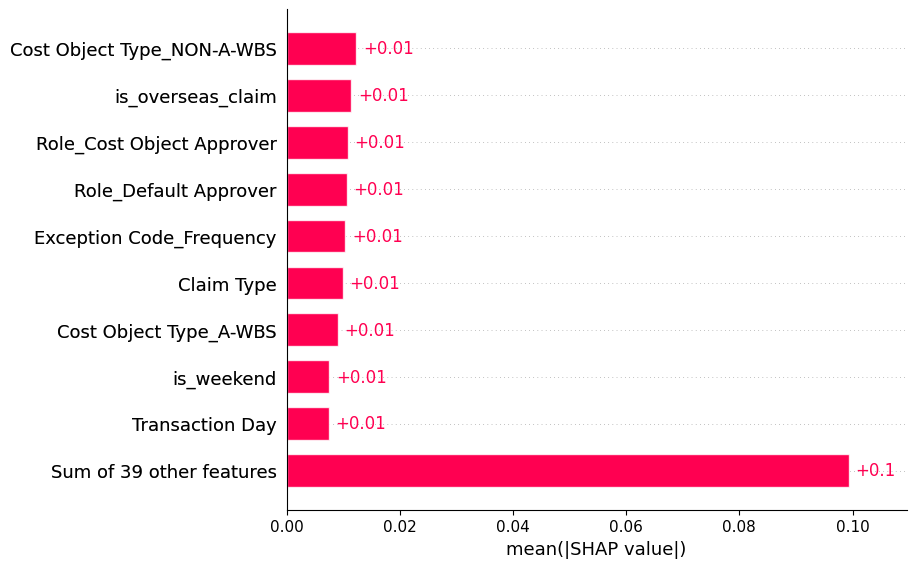

In [409]:
# AE
criterion = nn.MSELoss() 
activity_lambda = 0.01

ae_3 = AutoencoderWrapper(name = 'on normal df', criterion=criterion, cv='id_based', activity_lambda=activity_lambda)
train_loader, val_loader = ae_3.get_train_test(normal_df)

ae_3.set_up_model(encoding_dim=16)

loss_df_3 = ae_3.train(train_loader, val_loader)

shap_values_3 = ae_3.get_shap()

In [410]:
bottleneck_df_3, reconstruct_error_df_3 = ae_3.get_bottleneck_and_error(new_df=df_scaled.drop(columns=['Employee ID']))

In [411]:
bottleneck_df_3.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000,636006.000000
mean,-2.129745,-0.627087,5.673324,5.045734,2.198193,2.009184,-3.232231,3.194874,-0.546208,1.615262,0.610479,0.197775,2.387786,0.056214,0.499140,1.585061
std,1.434024,2.094591,1.287108,1.760919,1.508910,1.294352,1.375533,1.498917,1.756716,1.889312,1.687564,1.371987,1.509088,1.628116,1.610777,2.053836
min,-34.543060,-57.829475,-0.259899,-1.351717,-2.229131,-31.367903,-9.508286,-55.347511,-122.605354,-40.746941,-5.851938,-4.489245,-2.766592,-9.832477,-30.421583,-2.798251
25%,-3.160103,-2.001017,4.852770,3.838414,1.159893,1.181667,-4.084345,2.207388,-1.725087,0.368209,-0.417881,-0.763122,1.392389,-1.024810,-0.685204,0.003743
50%,-2.309501,-0.691892,5.694837,5.031768,2.165474,2.004239,-3.007760,3.120825,-0.798631,1.700799,0.556566,0.121428,2.061448,-0.113793,0.772259,1.276068
75%,-1.245169,1.259920,6.530342,6.220205,3.115924,2.855029,-2.283852,4.080428,0.495756,2.789736,1.662394,1.040799,3.422792,1.302010,1.889791,2.730515
max,5.947401,6.443555,57.182056,109.306709,34.426193,9.147821,26.546013,8.737480,4.816997,9.819303,48.670433,54.887939,12.295743,14.602839,4.033191,40.213402


For model IForest built on AE (id-based CV) (remove 1st quarter):
                          model_name  num_anomaly_claim  perc_anomaly_claim  \
0  IForest built on AE (id-based CV)              45866              0.0721   

   num_claimnts_with_ano_claims  perc_claimnts_with_ano_claims  \
0                          6505                         0.4418   

   num_suspicious_claimnts  perc_suspisiou_claimnts  
0                     6505                   0.4418  


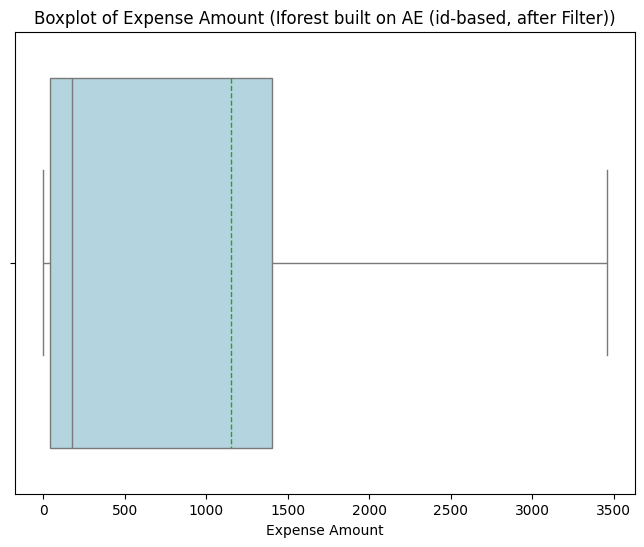

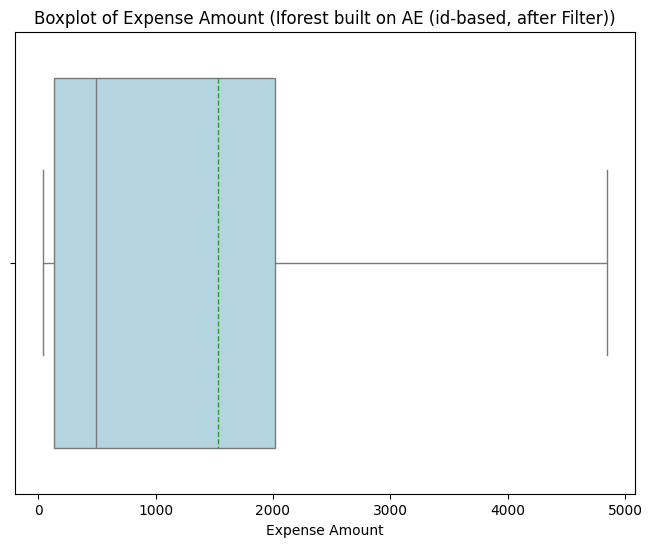

In [412]:
# IF
ifor_1=IForestWrapper('built on AE (id-based, after Filter)')
ifor_1.set_up_model()
metrics_df_if_1 = ifor_1.fit_and_predict(bottleneck_df_3) 
anomalies_df_if_1, ano_claimant_df_if_1, anomaly_result_df_if_1, new_anomalies_df_if_1, new_ano_claimant_df_if_1, new_anomaly_result_df_if_1  = iforest_1.get_anomalies(df_encoded, metrics_df_if_1)
ifor_1.visualize_boxplot(anomalies_df_if_1)
ifor_1.visualize_boxplot(new_anomalies_df_if_1)
ad_result_df = ifor_1.update_ad_result(ad_result_df, anomalies_df_if_1, anomaly_result_df_if_1)
new_ad_result_df = ifor_1.update_ad_result(new_ad_result_df, new_anomalies_df_if_1, new_anomaly_result_df_if_1)

For model IForest built on AE (id-based,after Filter) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (id-based,after Filter) + ...              41553   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0653                          6306   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4283                     6306   

   perc_suspisiou_claimnts  
0                   0.4283  


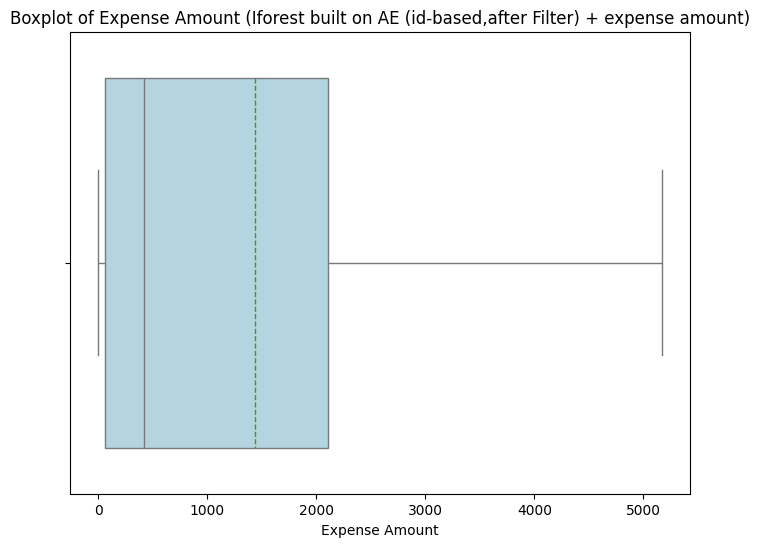

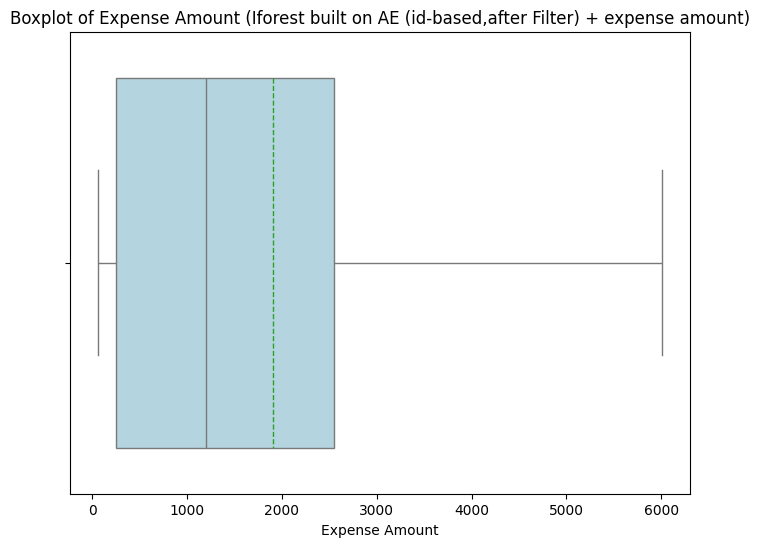

In [413]:
ifor_2=IForestWrapper('built on AE (id-based,after Filter) + expense amount')
ifor_2.set_up_model()
X_if_2 = bottleneck_df_3.copy()
X_if_2[16] = df_scaled['Expense Amount']
metrics_df_if_2 = ifor_2.fit_and_predict(X_if_2) 
anomalies_df_if_2, ano_claimant_df_if_2, anomaly_result_df_if_2, new_anomalies_df_if_2, new_ano_claimant_df_if_2, new_anomaly_result_df_if_2 = ifor_2.get_anomalies(df_encoded, metrics_df_if_2)
ifor_2.visualize_boxplot(anomalies_df_if_2)
ifor_2.visualize_boxplot(new_anomalies_df_if_2)
ad_result_df = ifor_2.update_ad_result(ad_result_df, anomalies_df_if_2, anomaly_result_df_if_2)
new_ad_result_df = ifor_2.update_ad_result(new_ad_result_df, new_anomalies_df_if_2, new_anomaly_result_df_if_2)

For model IForest built on AE error (id,after Filter) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE error (id,after Filter) + ...              60167   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0946                          7189   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4883                     7189   

   perc_suspisiou_claimnts  
0                   0.4883  


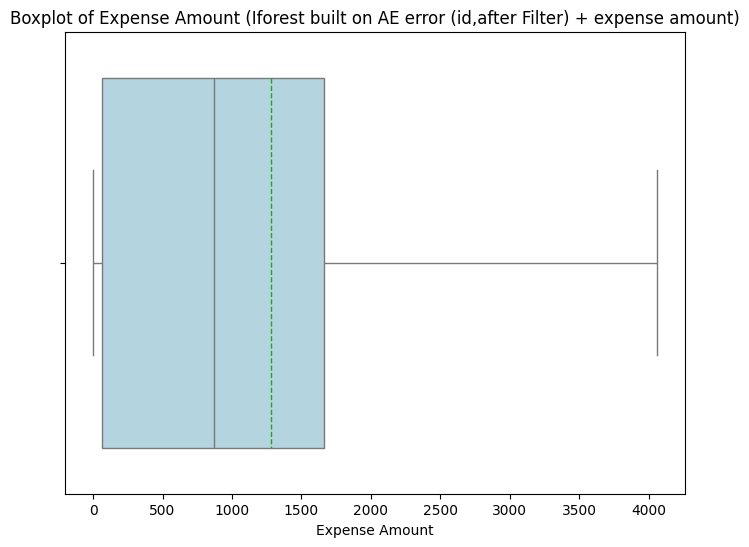

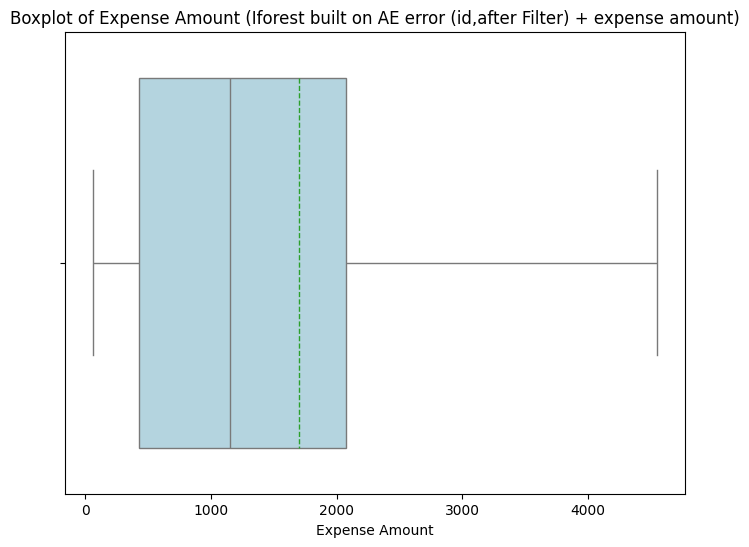

In [414]:
ifor_3=IForestWrapper('built on AE error (id,after Filter) + expense amount')
ifor_3.set_up_model()
X_if_3 = reconstruct_error_df_3.copy()
X_if_3['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_if_3 = ifor_3.fit_and_predict(X_if_3) 
anomalies_df_if_3, ano_claimant_df_if_3, anomaly_result_df_if_3, new_anomalies_df_if_3, new_ano_claimant_df_if_3, new_anomaly_result_df_if_3 = ifor_3.get_anomalies(df_encoded, metrics_df_if_3)
ifor_3.visualize_boxplot(anomalies_df_if_3)
ifor_3.visualize_boxplot(new_anomalies_df_if_3)
ad_result_df = ifor_3.update_ad_result(ad_result_df, anomalies_df_if_3, anomaly_result_df_if_3)
new_ad_result_df = ifor_3.update_ad_result(new_ad_result_df, new_anomalies_df_if_3, new_anomaly_result_df_if_3)

For model IForest built on AE (id, after Filter) + error + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (id, after Filter) + error...              33338   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0524                          5450   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.3701                     5450   

   perc_suspisiou_claimnts  
0                   0.3701  


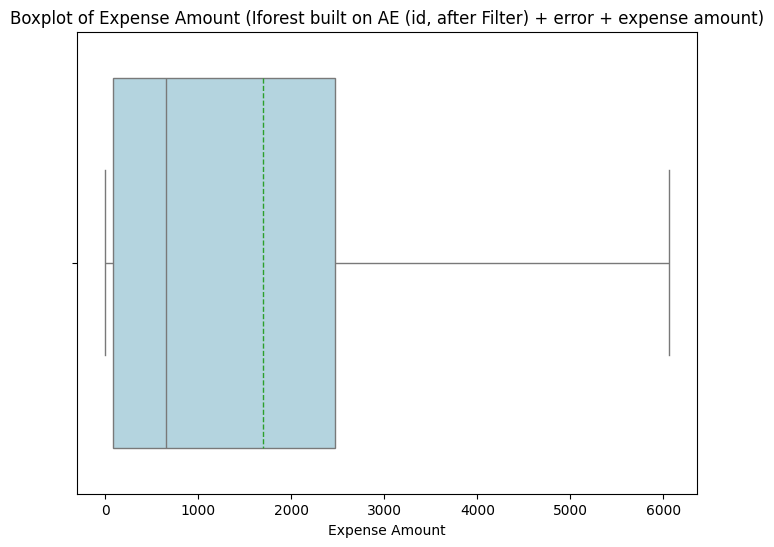

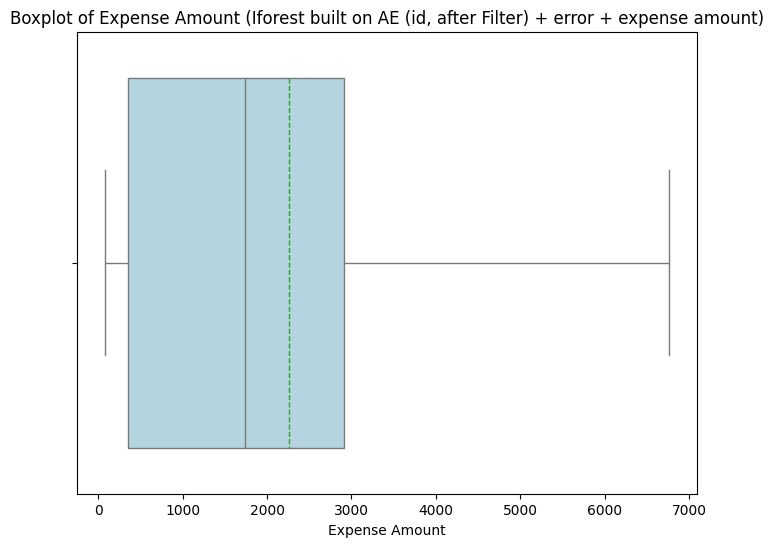

In [415]:
ifor_4=IForestWrapper('built on AE (id, after Filter) + error + expense amount')
ifor_4.set_up_model()
X_if_4 = bottleneck_df_3.copy()
X_if_4[16] = reconstruct_error_df_3['reconstruction_error']
X_if_4[17] = df_scaled['Expense Amount']
metrics_df_if_4 = ifor_4.fit_and_predict(X_if_4) 
anomalies_df_if_4, ano_claimant_df_if_4, anomaly_result_df_if_4, new_anomalies_df_if_4, new_ano_claimant_df_if_4, new_anomaly_result_df_if_4 = ifor_4.get_anomalies(df_encoded, metrics_df_if_4)
ifor_4.visualize_boxplot(anomalies_df_if_4)
ifor_4.visualize_boxplot(new_anomalies_df_if_4)
ad_result_df = ifor_4.update_ad_result(ad_result_df, anomalies_df_if_4, anomaly_result_df_if_4)
new_ad_result_df = ifor_4.update_ad_result(new_ad_result_df, new_anomalies_df_if_4, new_anomaly_result_df_if_4)

##### AE: claim based CV

/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01431981 0.01193317 0.01431981 ... 0.05011933 0.         0.00238663]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.08285946 0.08042242 0.09260764 ... 0.14784728 0.08610885 0.07879773]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[train_idxs] = X_train_scaled
/var/folders/7z/n94lplm97l56fkms2nv7mjw40000gn/T/ipykernel_13529/1401021623.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

Epoch [1/50], Training Loss: 0.3115, Validation Loss: 0.4881
Epoch [2/50], Training Loss: 0.5003, Validation Loss: 0.4963
Epoch [3/50], Training Loss: 0.4457, Validation Loss: 0.4051
Epoch [4/50], Training Loss: 0.4029, Validation Loss: 0.3810
Epoch [5/50], Training Loss: 0.3611, Validation Loss: 0.3233
Epoch [6/50], Training Loss: 0.3132, Validation Loss: 0.2761
Epoch [7/50], Training Loss: 0.2796, Validation Loss: 0.2540
Epoch [8/50], Training Loss: 0.2471, Validation Loss: 0.2224
Epoch [9/50], Training Loss: 0.2200, Validation Loss: 0.1984
Epoch [10/50], Training Loss: 0.2004, Validation Loss: 0.1911
Epoch [11/50], Training Loss: 0.1942, Validation Loss: 0.1784
Epoch [12/50], Training Loss: 0.1800, Validation Loss: 0.1700
Epoch [13/50], Training Loss: 0.1684, Validation Loss: 0.1580
Epoch [14/50], Training Loss: 0.1551, Validation Loss: 0.1261
Epoch [15/50], Training Loss: 0.1375, Validation Loss: 0.1272
Epoch [16/50], Training Loss: 0.1380, Validation Loss: 0.1310
Epoch [17/50], Tr

  0%|          | 0/100 [00:00<?, ?it/s]

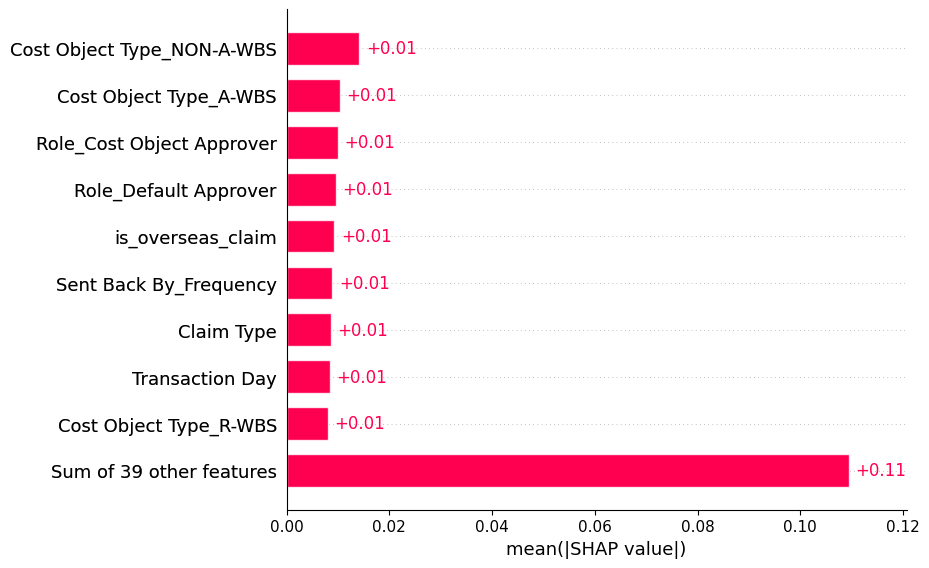

In [416]:
criterion = nn.MSELoss() 
activity_lambda = 0.01

ae_4 = AutoencoderWrapper(name = 'on normal df', criterion=criterion, cv='claim_based', activity_lambda=activity_lambda)
train_loader, val_loader = ae_4.get_train_test(normal_df)

ae_4.set_up_model(encoding_dim=16)

loss_df_4 = ae_4.train(train_loader, val_loader)

shap_values_4 = ae_4.get_shap()

In [417]:
bottleneck_df_4, reconstruct_error_df_4 = ae_4.get_bottleneck_and_error(new_df=df_scaled.drop(columns=['Employee ID']))

For model IForest built on AE (claim-based, after Filter) (remove 1st quarter):
                                        model_name  num_anomaly_claim  \
0  IForest built on AE (claim-based, after Filter)              44804   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0704                          6220   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4224                     6220   

   perc_suspisiou_claimnts  
0                   0.4224  


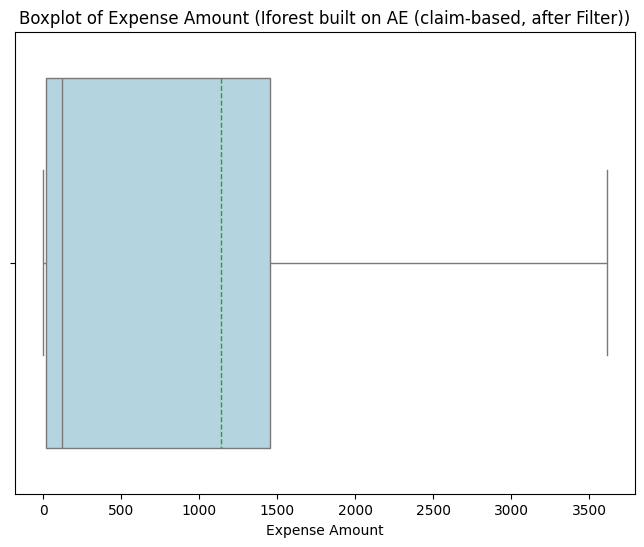

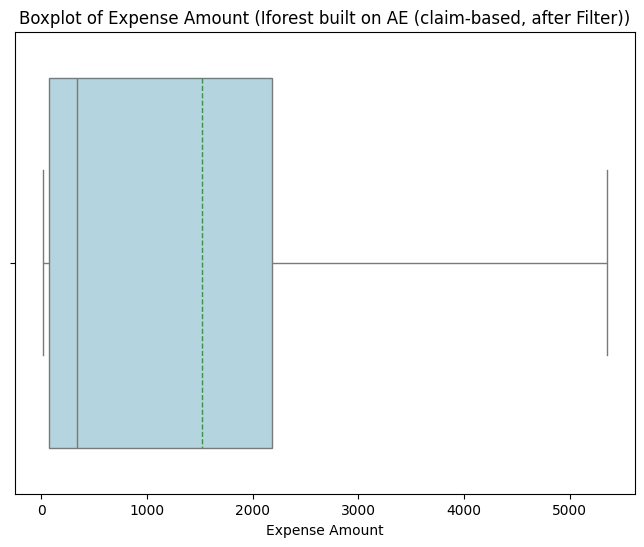

In [418]:
ifor_5=IForestWrapper('built on AE (claim-based, after Filter)')
ifor_5.set_up_model()
metrics_df_if_5 = ifor_5.fit_and_predict(bottleneck_df_4) 
anomalies_df_if_5, ano_claimant_df_if_5, anomaly_result_df_if_5, new_anomalies_df_if_5, new_ano_claimant_df_if_5, new_anomaly_result_df_if_5 = ifor_5.get_anomalies(df_encoded, metrics_df_if_5)
ifor_5.visualize_boxplot(anomalies_df_if_5)
ifor_5.visualize_boxplot(new_anomalies_df_if_5)
ad_result_df = ifor_5.update_ad_result(ad_result_df, anomalies_df_if_5, anomaly_result_df_if_5)
new_ad_result_df = ifor_5.update_ad_result(new_ad_result_df, new_anomalies_df_if_5, new_anomaly_result_df_if_5)

For model IForest built on AE (claim-based,after Filter) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (claim-based,after Filter)...              35439   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0557                          5808   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.3945                     5808   

   perc_suspisiou_claimnts  
0                   0.3945  


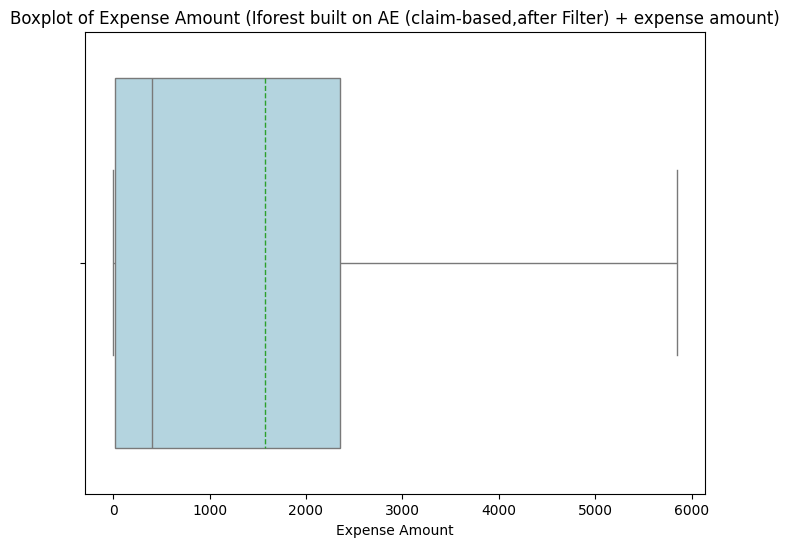

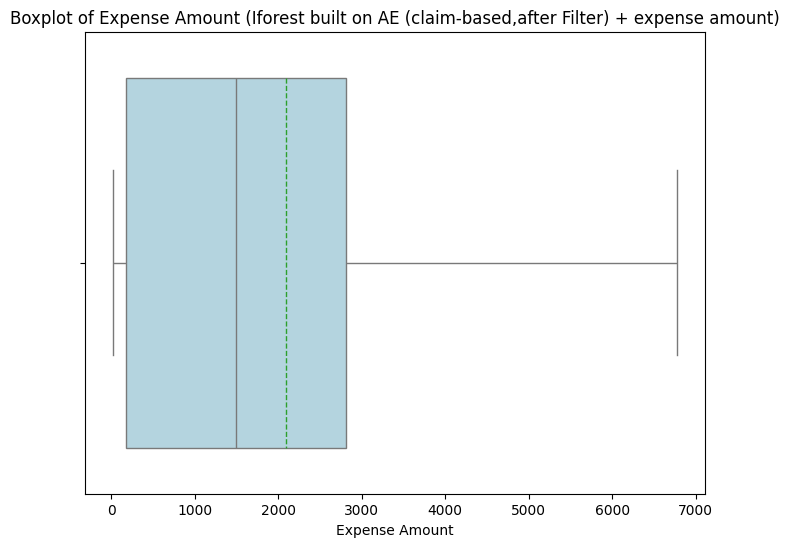

In [419]:
ifor_6=IForestWrapper('built on AE (claim-based,after Filter) + expense amount')
ifor_6.set_up_model()
X_if_6 = bottleneck_df_4.copy()
X_if_6[16] = df_scaled['Expense Amount']
metrics_df_if_6 = ifor_6.fit_and_predict(X_if_6) 
anomalies_df_if_6, ano_claimant_df_if_6, anomaly_result_df_if_6, new_anomalies_df_if_6, new_ano_claimant_df_if_6, new_anomaly_result_df_if_6 = ifor_6.get_anomalies(df_encoded, metrics_df_if_6)
ifor_6.visualize_boxplot(anomalies_df_if_6)
ifor_6.visualize_boxplot(new_anomalies_df_if_6)
ad_result_df = ifor_6.update_ad_result(ad_result_df, anomalies_df_if_6, anomaly_result_df_if_6)
new_ad_result_df = ifor_6.update_ad_result(new_ad_result_df, new_anomalies_df_if_6, new_anomaly_result_df_if_6)

For model IForest built on AE error (claim,after Filter) + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE error (claim,after Filter)...              44336   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0697                          6692   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.4545                     6692   

   perc_suspisiou_claimnts  
0                   0.4545  


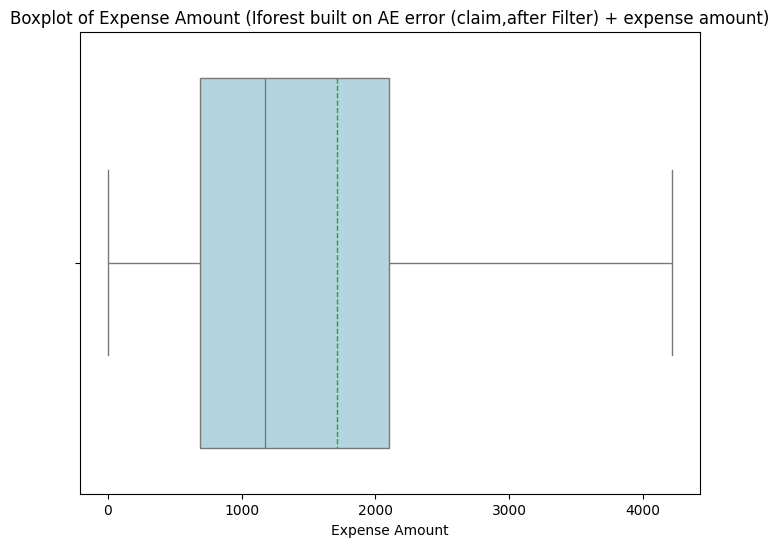

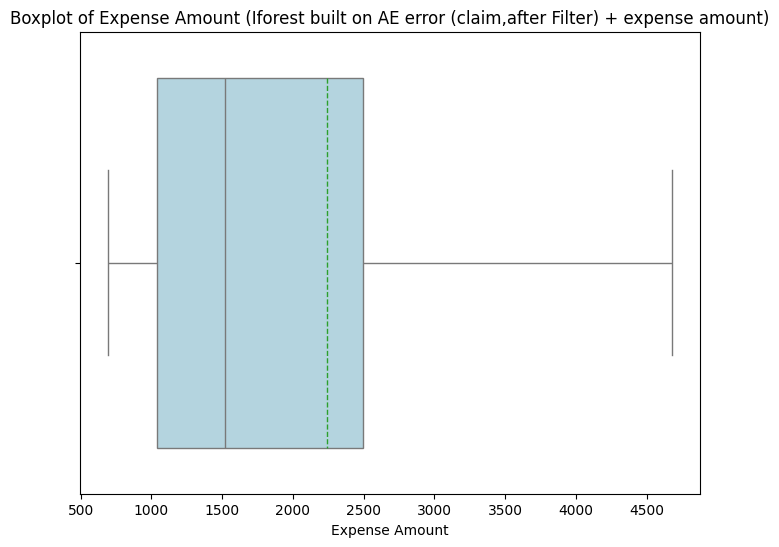

In [420]:
ifor_7=IForestWrapper('built on AE error (claim,after Filter) + expense amount')
ifor_7.set_up_model()
X_if_7 = reconstruct_error_df_4.copy()
X_if_7['Expense Amount'] = df_scaled['Expense Amount']
metrics_df_if_7 = ifor_7.fit_and_predict(X_if_7) 
anomalies_df_if_7, ano_claimant_df_if_7, anomaly_result_df_if_7, new_anomalies_df_if_7, new_ano_claimant_df_if_7, new_anomaly_result_df_if_7 = ifor_7.get_anomalies(df_encoded, metrics_df_if_7)
ifor_7.visualize_boxplot(anomalies_df_if_7)
ifor_7.visualize_boxplot(new_anomalies_df_if_7)
ad_result_df = ifor_7.update_ad_result(ad_result_df, anomalies_df_if_7, anomaly_result_df_if_7)
new_ad_result_df = ifor_7.update_ad_result(new_ad_result_df, new_anomalies_df_if_7, new_anomaly_result_df_if_7)

For model IForest built on AE (claim, after Filter) + error + expense amount (remove 1st quarter):
                                          model_name  num_anomaly_claim  \
0  IForest built on AE (claim, after Filter) + er...              27566   

   perc_anomaly_claim  num_claimnts_with_ano_claims  \
0              0.0433                          5692   

   perc_claimnts_with_ano_claims  num_suspicious_claimnts  \
0                         0.3866                     5692   

   perc_suspisiou_claimnts  
0                   0.3866  


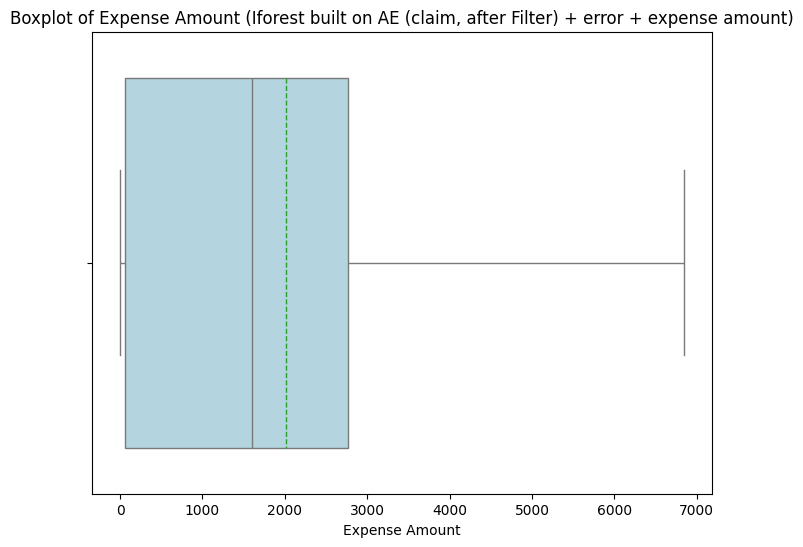

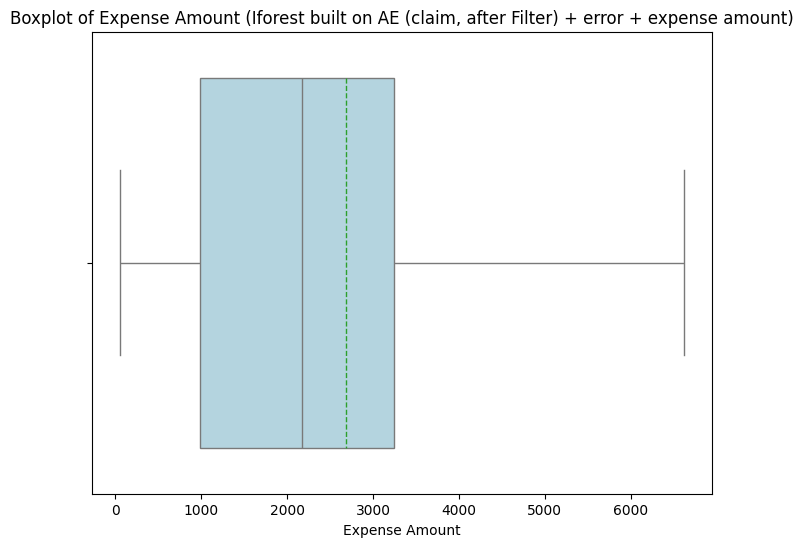

In [421]:
ifor_8=IForestWrapper('built on AE (claim, after Filter) + error + expense amount')
ifor_8.set_up_model()
X_if_8 = bottleneck_df_4.copy()
X_if_8[16] = reconstruct_error_df_4['reconstruction_error']
X_if_8[17] = df_scaled['Expense Amount']
metrics_df_if_8 = ifor_8.fit_and_predict(X_if_8) 
anomalies_df_if_8, ano_claimant_df_if_8, anomaly_result_df_if_8, new_anomalies_df_if_8, new_ano_claimant_df_if_8, new_anomaly_result_df_if_8 = ifor_8.get_anomalies(df_encoded, metrics_df_if_8)
ifor_8.visualize_boxplot(anomalies_df_if_8)
ifor_8.visualize_boxplot(new_anomalies_df_if_8)
ad_result_df = ifor_8.update_ad_result(ad_result_df, anomalies_df_if_8, anomaly_result_df_if_8)
new_ad_result_df = ifor_8.update_ad_result(new_ad_result_df, new_anomalies_df_if_8, new_anomaly_result_df_if_8)

In [422]:
ad_result_df.drop_duplicates(inplace=True)
ad_result_df

,model_name,perc_anomaly_claim,perc_claimnts_with_ano_claims,perc_suspisiou_claimnts,avg_expense,min_expense,quarter1_expense,median_expense,quarter3_expense,max_expense,num_anomaly_claim,num_claimnts_with_ano_claims,num_suspicious_claimnts
0,IForest baseline,0.0982,0.3523,0.0564,1024.669368,0.004286,27.0100,133.340,1001.0000,291107.4,62439,5188,830
1,IForest built on AE (id-based CV),0.0182,0.2390,0.0096,2520.421379,0.040000,118.0000,1485.035,3000.0000,291107.4,11562,3519,142
2,IForest built on AE (claim-based CV),0.0110,0.1071,0.0049,803.982584,0.010000,30.4500,109.050,509.8800,291107.4,6999,1577,72
3,IForest built on AE (id-based CV) + expense am...,0.0233,0.2762,0.0107,3082.926034,0.040000,503.9425,2247.150,3928.7300,291107.4,14810,4067,157
4,IForest built on AE (claim-based CV) + expense...,0.0106,0.1206,0.0039,2861.234514,0.200000,131.4200,1250.000,3713.6000,291107.4,6753,1776,57
5,IForest built on AE error (id-based),0.0732,0.4599,0.0541,1783.352192,0.004286,180.0000,1379.530,2422.4700,291107.4,46551,6772,796
6,IForest built on AE error (id-based) + expense...,0.1096,0.5534,0.0834,1520.512371,0.004286,320.2900,999.000,1863.9000,291107.4,69695,8148,1228
7,IForest built on AE(id) + error,0.0531,0.3570,0.0333,1737.436840,0.004286,32.4275,252.255,2699.4775,291107.4,33802,5257,490
8,IForest built on AE(id) + error + expense,0.0524,0.4169,0.0405,2182.011703,0.004286,169.5000,1703.000,2914.3900,291107.4,33325,6139,597
9,IForest built on AE error (claim-based),0.0891,0.4422,0.0437,1436.935684,0.008750,18.0000,185.720,2144.4700,291107.4,56651,6511,644


In [423]:
# box plot of all models?
new_ad_result_df


,model_name,perc_anomaly_claim,perc_claimnts_with_ano_claims,perc_suspisiou_claimnts,avg_expense,min_expense,quarter1_expense,median_expense,quarter3_expense,max_expense,num_anomaly_claim,num_claimnts_with_ano_claims,num_suspicious_claimnts
0,IForest baseline,0.0736,0.3407,0.3407,1361.916880,27.0200,96.8150,309.6625,1648.7050,291107.4,46827,5016,5016
1,IForest built on AE (id-based CV),0.0136,0.2173,0.2173,3347.964703,118.9000,1000.5750,2245.9450,3746.4225,291107.4,8668,3200,3200
2,IForest built on AE (claim-based CV),0.0083,0.0882,0.0882,1066.705007,30.5500,82.4850,209.0000,894.2675,291107.4,5248,1299,1299
3,IForest built on AE (id-based CV) + expense am...,0.0175,0.2478,0.2478,4079.831899,504.7000,1949.6000,2855.0100,4782.0000,291107.4,11107,3649,3649
4,IForest built on AE (claim-based CV) + expense...,0.0080,0.1117,0.1117,3800.578047,131.5700,897.5475,2339.7550,4591.1000,291107.4,5064,1644,1644
5,IForest built on AE error (id-based),0.0549,0.4416,0.4416,2366.806582,180.0232,625.0125,1833.8000,2850.5220,291107.4,34886,6502,6502
6,IForest built on AE error (id-based) + expense...,0.0822,0.4983,0.4983,1984.553667,320.3300,893.8950,1305.0000,2252.6050,291107.4,52271,7337,7337
7,IForest built on AE(id) + error,0.0399,0.3399,0.3399,2311.808982,32.4500,143.0200,1260.0000,3327.3500,291107.4,25351,5005,5005
8,IForest built on AE(id) + error + expense,0.0393,0.3727,0.3727,2891.538721,169.5100,1240.1000,2272.4000,3418.8900,291107.4,24993,5487,5487
9,IForest built on AE error (claim-based),0.0668,0.4175,0.4175,1912.873933,18.0100,73.8200,1580.0400,2556.9000,291107.4,42487,6148,6148


##### Conclusion

1. observation on expense amount: two kinds of anomalies can be detected from the model (extreme large and extreme small) -> remove the first quarter first
1. good models: 
    AE(id-based) + IFor + expense amount; 
    IF filter + AE(claim-based) + IFor + expense amount; 
    IF filter + AE(claim-based) + IFor + expense amount + error;
    IF filter + AE (id-based) + IFor + expense amount + error;
    AE (claim-based) + LOF (low percentage, expense quarter not ideal);


mistakes: scaling before CV 

# Indicator

## Observe: anomaly score

## Suspicious claimants + claims 
(space for improvement)